In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from pytensor import tensor as at
from matplotlib.patches import Ellipse, transforms
from scipy import stats

In [2]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"

In [3]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

#### Code 14.1

In [4]:
a = 3.5  # average morning wait time
b = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

#### Code 14.2

In [5]:
Mu = [a, b]

#### Code 14.3

In [6]:
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
Sigma

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

#### Code 14.4
R related and not relevant for Python.

#### Code 14.5

In [7]:
sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])

Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)
Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

#### Code 14.6

In [8]:
N_cafes = 20

#### Code 14.7

In [9]:
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)

#### Code 14.8

In [10]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

#### Code 14.9

In [11]:
def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * stats.chi2.ppf(level, 2))  # get size corresponding to level
        ell = Ellipse(
            mu[:2],
            v[0],
            v[1],
            180 + angle,
            facecolor="None",
            edgecolor="k",
            alpha=(1 - level) * 0.5,
            lw=1.5,
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    return ax

C:\Users\Kieran McGee\AppData\Local\Temp\ipykernel_30340\3340189249.py:13: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = Ellipse(


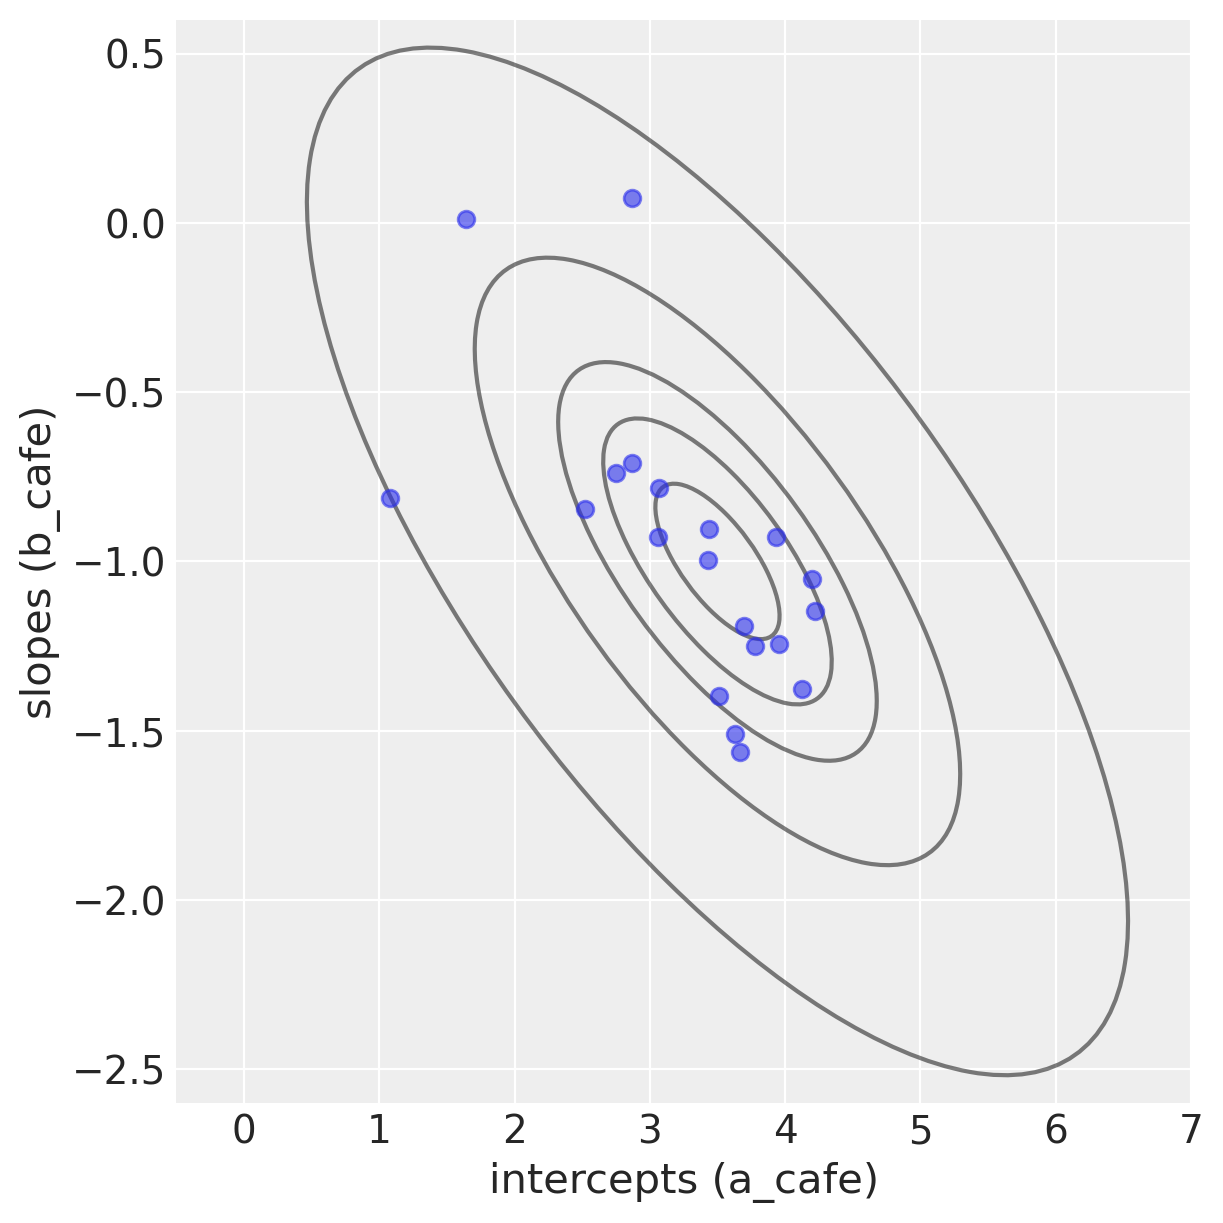

In [12]:
ax = Gauss2d(Mu, np.asarray(Sigma), [0.1, 0.3, 0.5, 0.8, 0.99])
ax.scatter(a_cafe, b_cafe, alpha=0.6)
ax.set_xlim(-0.5, 7)
ax.set_ylim(-2.6, 0.6)
ax.set_xlabel("intercepts (a_cafe)")
ax.set_ylabel("slopes (b_cafe)");

#### Code 14.10

In [13]:
N_visits = 10
afternoon = np.tile([0, 1], N_visits * N_cafes // 2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(loc=mu, scale=sigma, size=N_visits * N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
d

cafe  afternoon      wait
0       0          0  3.248747
1       0          1  2.354369
2       0          0  3.318056
3       0          1  1.485952
4       0          0  4.574328
..    ...        ...       ...
195    19          1  2.175432
196    19          0  3.824848
197    19          1  1.465361
198    19          0  3.510865
199    19          1  1.818971

[200 rows x 3 columns]

#### Code 14.11

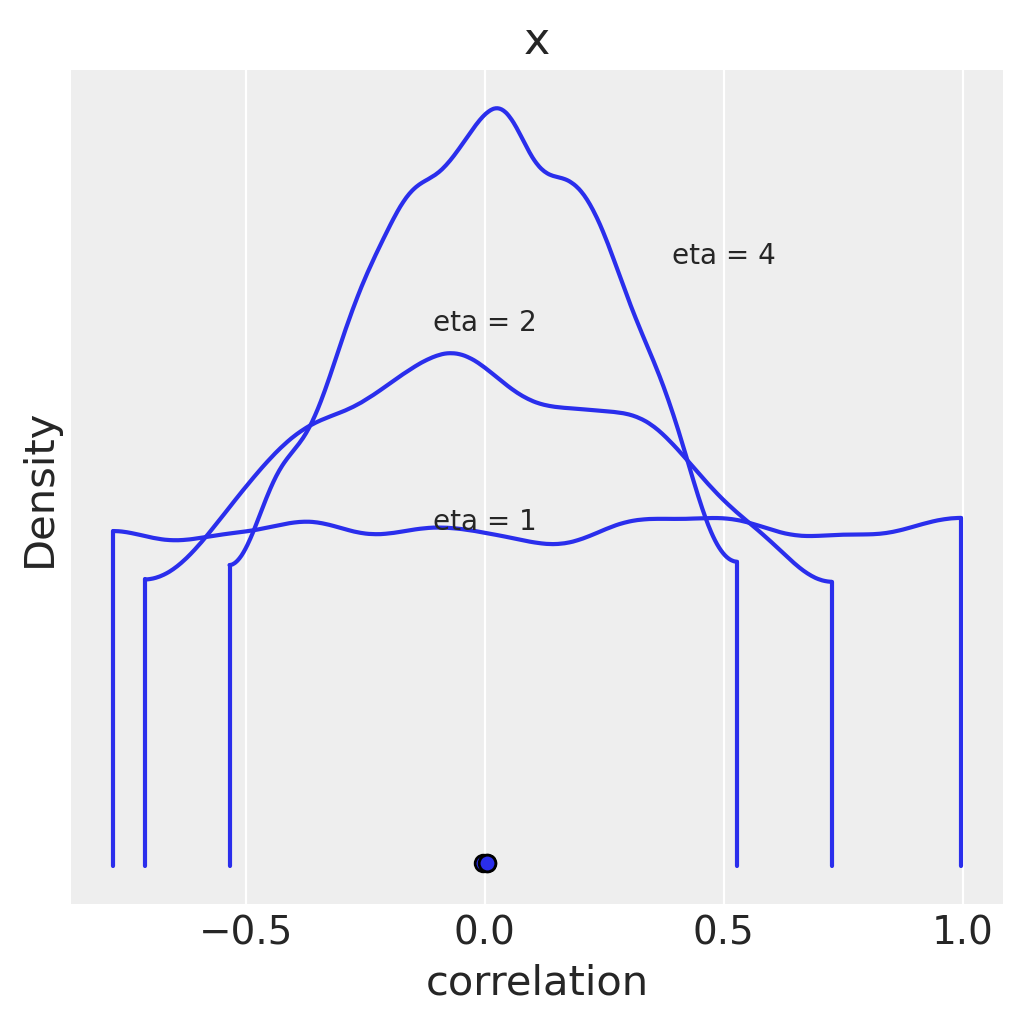

In [14]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
textloc = [[0, 0.5], [0, 0.8], [0.5, 0.9]]

for eta, loc in zip([1, 2, 4], textloc):
    R = pm.LKJCorr.dist(n=2, eta=eta, size=10000).eval()
    az.plot_density(R, ax=ax, backend_kwargs={"alpha": 0.8})
    ax.text(loc[0], loc[1], "eta = %s" % (eta), horizontalalignment="center")

ax.set_xlabel("correlation")
ax.set_ylabel("Density");

#### Code 14.12

In [15]:
cafe_idx = d["cafe"].values
with pm.Model() as m14_1:
    # LKJCholeskyCov is more efficient than LKJCorr
    # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    a = pm.Normal("a", 5.0, 2.0)  # prior for average intercept
    b = pm.Normal("b", -1.0, 0.5)  # prior for average slope
    ab_cafe = pm.MvNormal(
        "ab_cafe", mu=at.stack([a, b]), chol=chol, shape=(N_cafes, 2)
    )  # population of varying effects
    # shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe

    mu = ab_cafe[cafe_idx, 0] + ab_cafe[cafe_idx, 1] * d["afternoon"].values  # linear model
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within cafes

    wait = pm.Normal("wait", mu=mu, sigma=sigma_within, observed=d["wait"].values)  # likelihood

    trace_14_1 = pm.sample(4000, tune=4000, target_accept=0.9)
    trace_14_1.rename({"chol_cov_corr": "Rho", "chol_cov_stds": "sigma_cafe"}, inplace=True)

post = trace_14_1.posterior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
G:\Statistical_Rethinking\rethinking\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: 

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 112 seconds.


For complex models it is always good to do more checks:

In [16]:
az.summary(trace_14_1, var_names=["a", "b", "sigma_within", "Rho", "sigma_cafe"], round_to=2)

G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a              3.29  0.21      2.97       3.62        0.0      0.0  15241.39   
b             -0.99  0.12     -1.18      -0.79        0.0      0.0  13816.86   
sigma_within   0.55  0.03      0.50       0.60        0.0      0.0  13122.06   
Rho[0, 0]      1.00  0.00      1.00       1.00        0.0      0.0  16000.00   
Rho[0, 1]     -0.54  0.21     -0.85      -0.23        0.0      0.0  10503.15   
Rho[1, 0]     -0.54  0.21     -0.85      -0.23        0.0      0.0  10503.15   
Rho[1, 1]      1.00  0.00      1.00       1.00        0.0      0.0  15284.24   
sigma_cafe[0]  0.89  0.16      0.63       1.11        0.0      0.0   9836.15   
sigma_cafe[1]  0.43  0.12      0.23       0.62        0.0      0.0   3300.25   

               ess_tail  r_hat  
a              11068.37    1.0  
b              12308.86    1.0  
sigma_within   10834.93    1.0  
Rho[0, 0]      16000.00    NaN  
Rho[0, 1]       9231.14    1.0  
Rho[1, 0]       9231.14    1.0  
Rho[1, 1]      15550.19    1.0  
sigma_cafe[0]   4754.17    1.0  
sigma_cafe[1]   2006.25    1.0

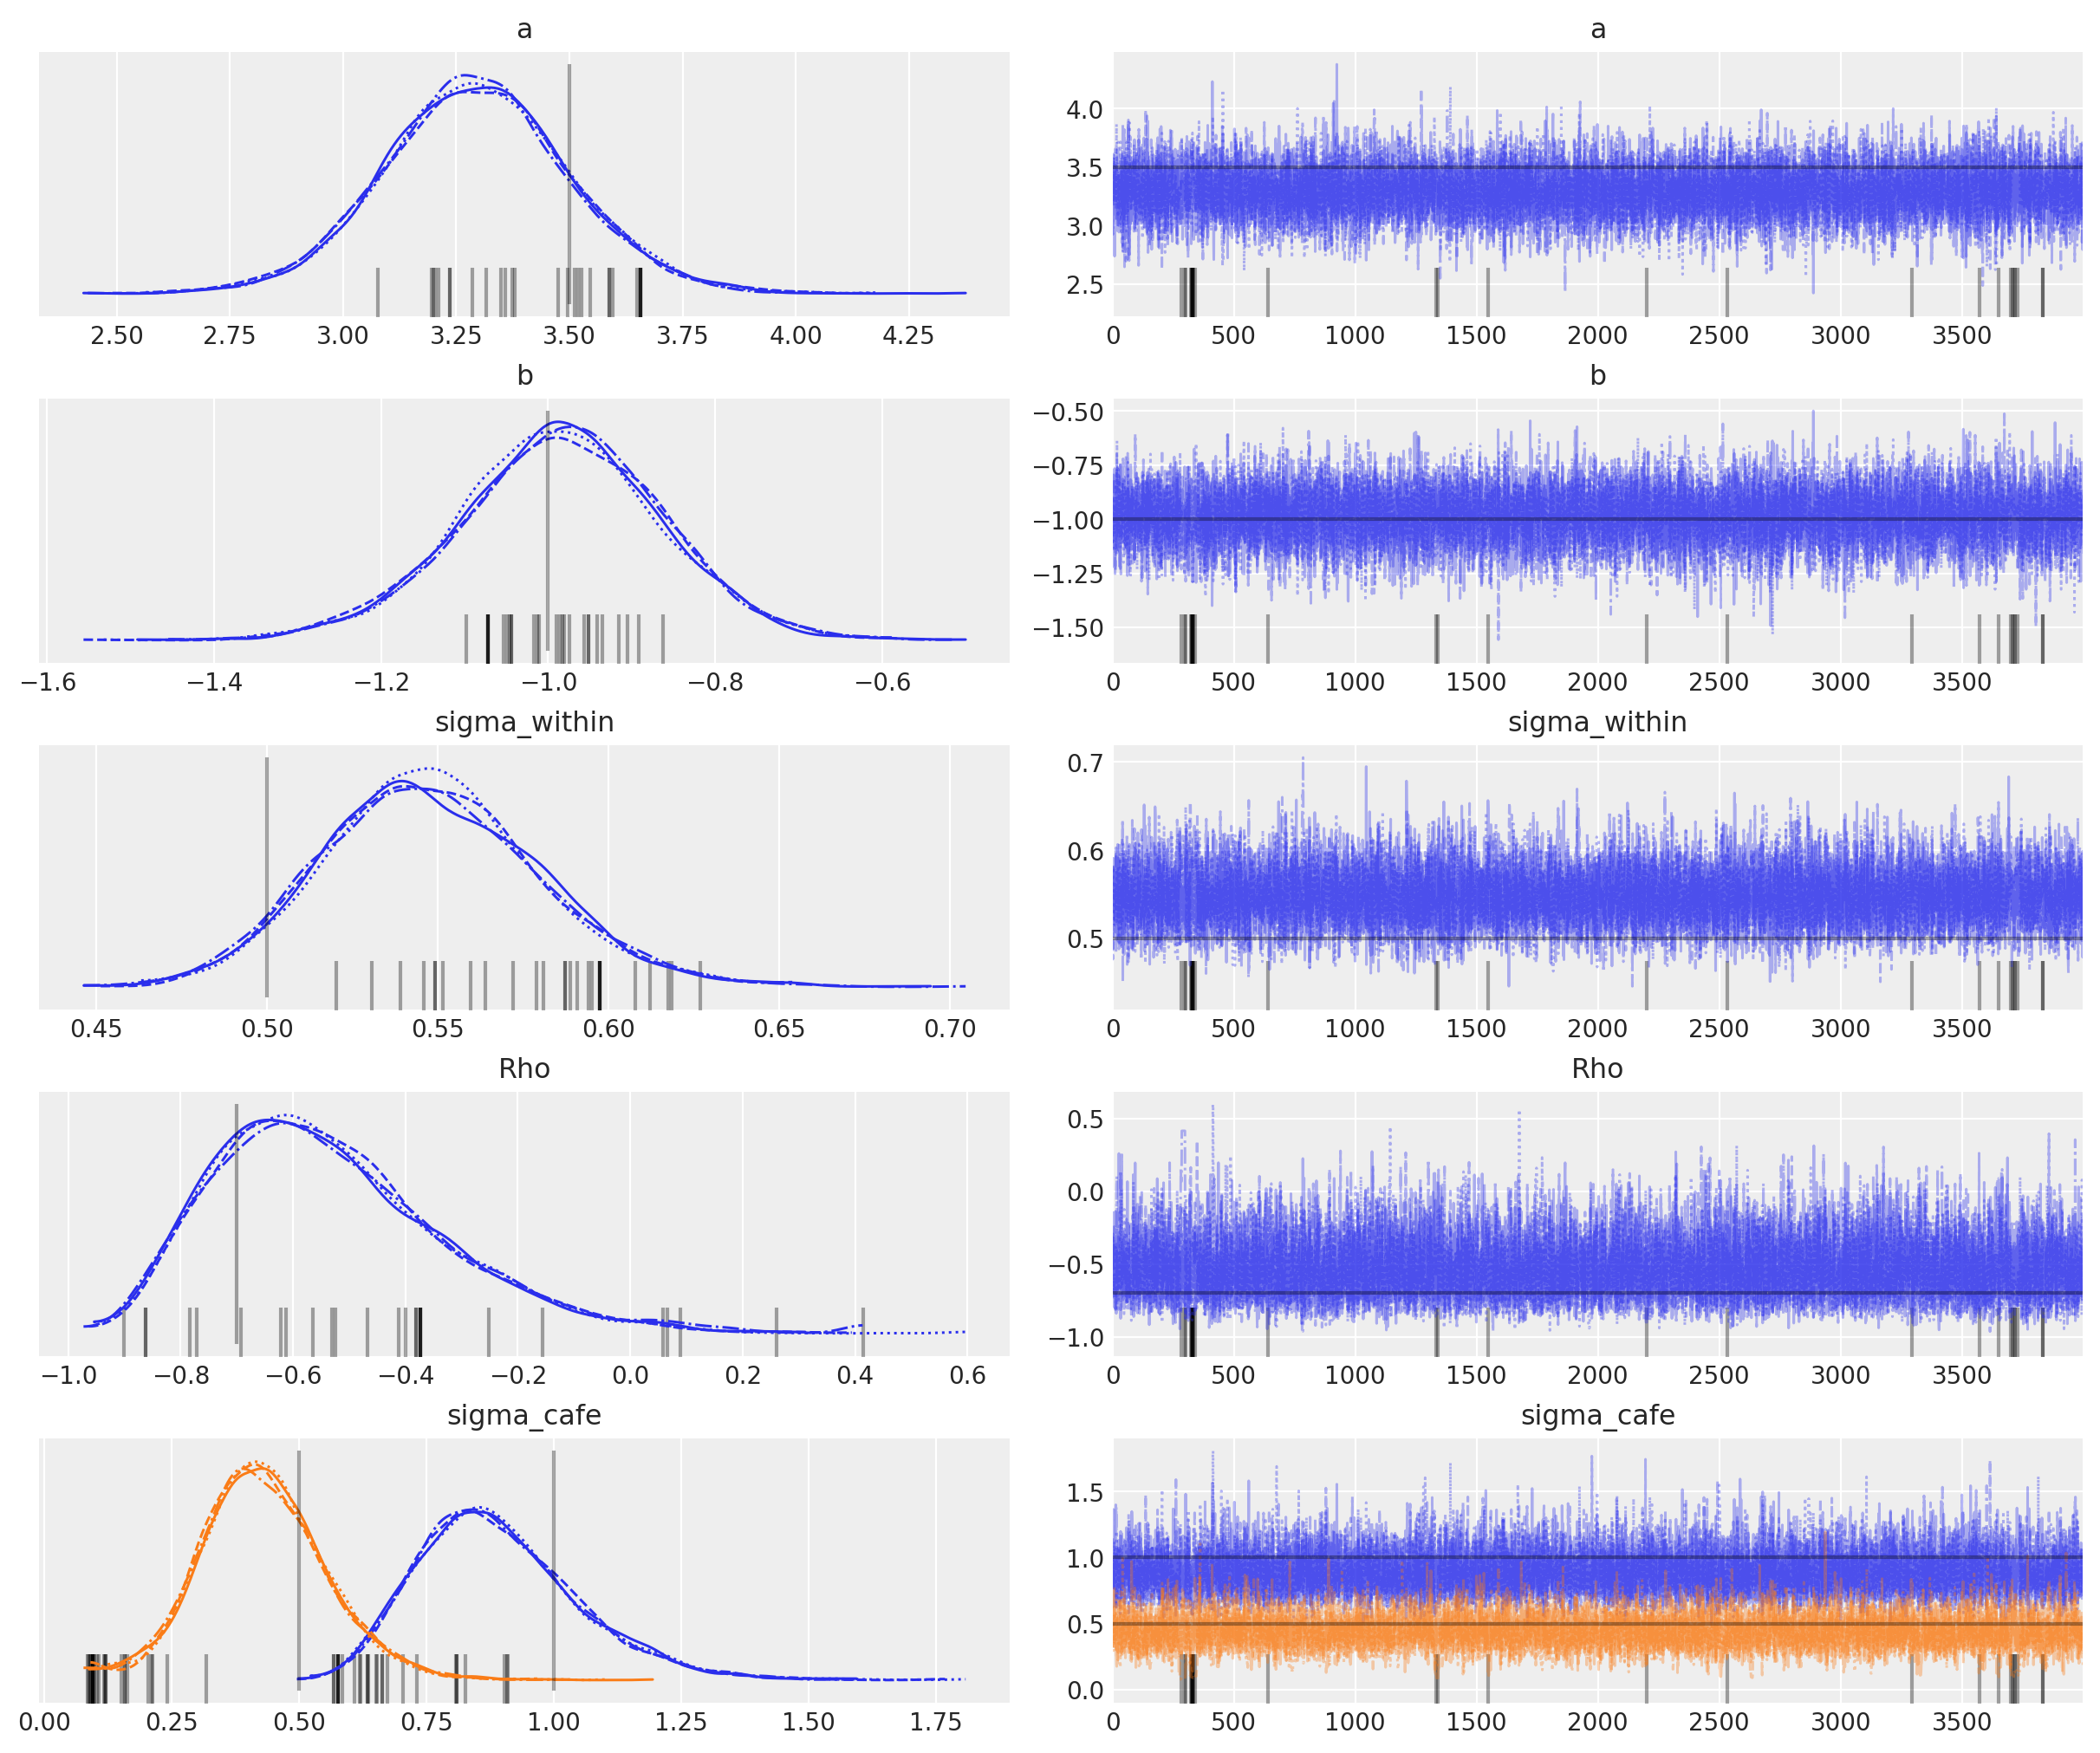

In [17]:
az.plot_trace(
    trace_14_1,
    compact=True,
    var_names=["~ab_cafe", "~chol_cov"],
    coords={"chol_cov_corr_dim_0": 1, "chol_cov_corr_dim_1": 0},
    lines=[
        ("a", {}, Mu[0]),
        ("b", {}, Mu[1]),
        ("sigma_cafe", {}, sigmas),
        ("Rho", {}, Rho[0, 1]),
        ("sigma_within", {}, sigma),
    ],
);

#### Code 14.13

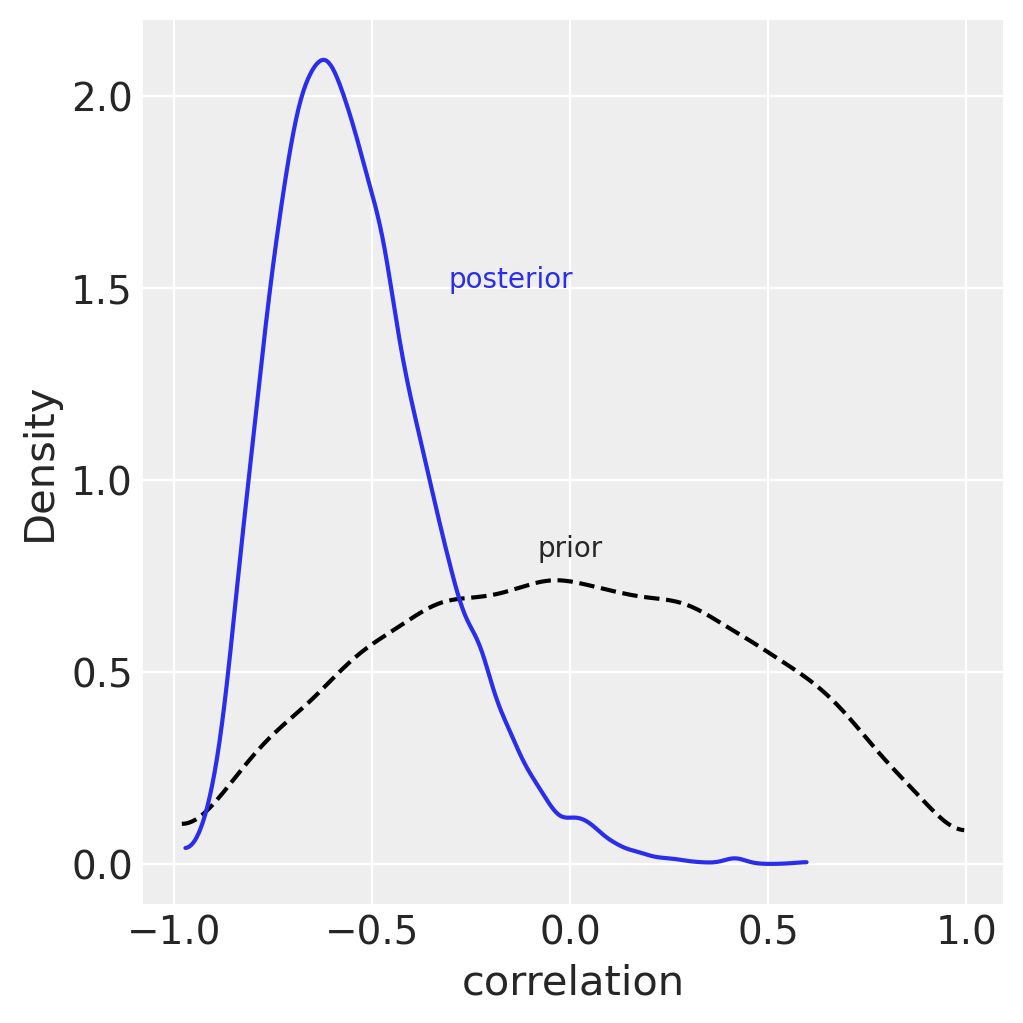

In [18]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

R = pm.LKJCorr.dist(n=2, eta=2, size=10000).eval()
az.plot_kde(R, plot_kwargs={"color": "k", "linestyle": "--"})
ax.text(0, 0.8, "prior", horizontalalignment="center")

az.plot_kde(
    np.array(
        az.extract_dataset(post["Rho"].sel(chol_cov_corr_dim_0=1, chol_cov_corr_dim_1=0)).to_array()
    ),
    ax=ax,
    plot_kwargs={"color": "C0"},
)
ax.text(-0.15, 1.5, "posterior", color="C0", horizontalalignment="center")

ax.set_xlabel("correlation")
ax.set_ylabel("Density");

#### Code 14.14 and 14.15

In [19]:
# compute unpooled estimates directly from data
a1b1 = d.groupby(["afternoon", "cafe"]).agg("mean").unstack(level=0).values
a1 = a1b1[:, 0]
b1 = a1b1[:, 1] - a1

# extract posterior means of partially pooled estimates
a2b2 = post["ab_cafe"].mean(dim=("chain", "draw"))
a2 = a2b2[:, 0]
b2 = a2b2[:, 1]

# compute posterior mean bivariate Gaussian
ab = post[["a", "b"]].mean(dim=("chain", "draw"))
Mu_est = np.array([ab["a"], ab["b"]])
chol_model = pm.expand_packed_triangular(
    2, post["chol_cov"].mean(dim=("chain", "draw")).to_numpy(), lower=True
).eval()
Sigma_est = np.dot(chol_model, chol_model.T)

C:\Users\Kieran McGee\AppData\Local\Temp\ipykernel_30340\3340189249.py:13: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = Ellipse(


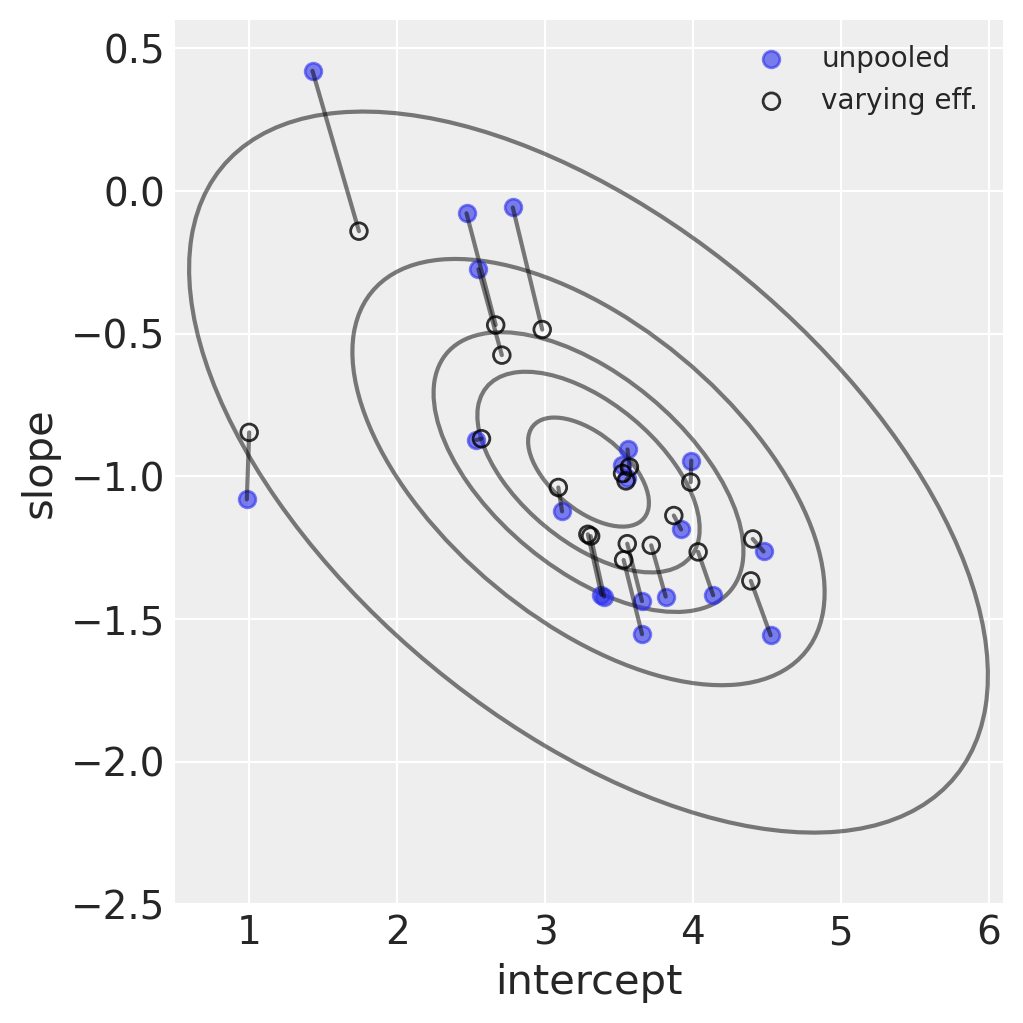

In [20]:
# draw contours
_, ax = plt.subplots(1, 1, figsize=(5, 5))
_ = Gauss2d(mu=Mu_est, cov=np.asarray(Sigma_est), ci=[0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)

# plot both and connect with lines
ax.scatter(a1, b1, label="unpooled", alpha=0.6)
ax.scatter(a2, b2, label="varying eff.", facecolors="none", edgecolors="k", lw=1, alpha=0.8)

ax.plot([a1, a2], [b1, b2], "k-", alpha=0.5)
ax.set_xlabel("intercept")
ax.set_ylabel("slope")
ax.set_xlim(0.5, 6.1)
ax.set_ylim(-2.5, 0.6)
plt.legend(fontsize=10);

#### Code 14.16 and 14.17

In [21]:
# convert varying effects to waiting times
wait_morning_1 = a1
wait_afternoon_1 = a1 + b1
wait_morning_2 = a2
wait_afternoon_2 = a2 + b2

# now shrinkage distribution by simulation
v = np.random.multivariate_normal(mean=Mu_est, cov=Sigma_est, size=1000)
v[:, 1] = v[:, 0] + v[:, 1]  # calculate afternoon wait
Sigma_est2 = np.cov(v.T)
Mu_est2 = Mu_est.copy()
Mu_est2[1] = Mu_est[0] + Mu_est[1]

C:\Users\Kieran McGee\AppData\Local\Temp\ipykernel_30340\3340189249.py:13: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = Ellipse(


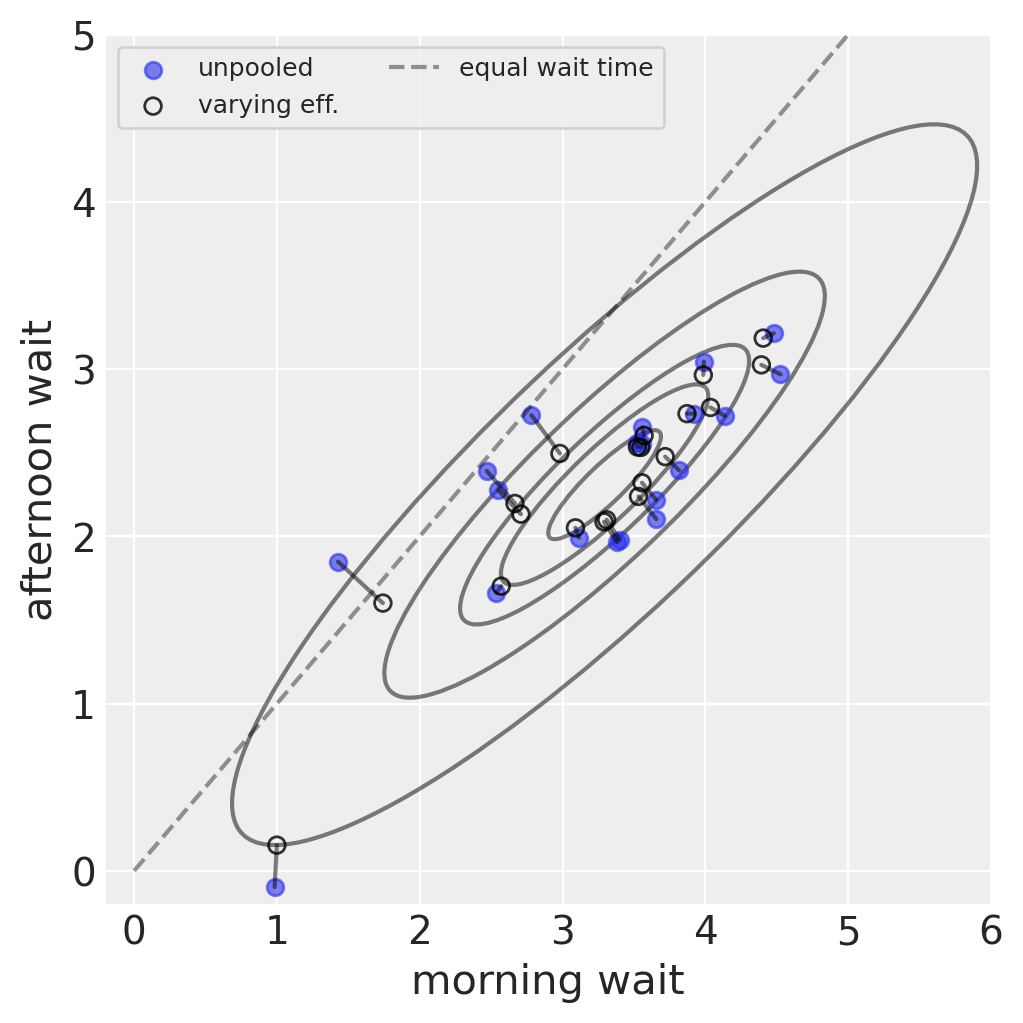

In [22]:
# draw contours
_, ax = plt.subplots(1, 1, figsize=(5, 5))
_ = Gauss2d(mu=Mu_est2, cov=np.asarray(Sigma_est2), ci=[0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)

# plot both and connect with lines
ax.scatter(wait_morning_1, wait_afternoon_1, label="unpooled", alpha=0.6)
ax.scatter(
    wait_morning_2,
    wait_afternoon_2,
    label="varying eff.",
    facecolors="none",
    edgecolors="k",
    lw=1,
    alpha=0.8,
)

ax.plot(
    [wait_morning_1, wait_morning_2],
    [wait_afternoon_1, wait_afternoon_2],
    "k-",
    alpha=0.5,
)
ax.plot(range(6), range(6), "k--", label="equal wait time", alpha=0.4)
ax.set_xlabel("morning wait")
ax.set_ylabel("afternoon wait")
ax.set_xlim(-0.2, 6)
ax.set_ylim(-0.2, 5)
plt.legend(fontsize=9, ncol=2, loc="upper left", frameon=True);

#### Code 14.18

In [23]:
d = pd.read_csv("Data/chimpanzees.csv", sep=";")

d["treatment"] = d.prosoc_left + 2 * d.condition
tid_ = d.treatment.values
Ntreatments = len(np.unique(tid_))

d["actor"] = d.actor - 1
actor_ = d.actor.astype(int).values
Nactors = len(np.unique(actor_))

d["block"] = d.block - 1
block_id_ = d.block.astype(int).values
Nblocks = len(np.unique(block_id_))

In [24]:
with pm.Model() as m14_2:
    # fixed priors
    g = pm.Normal("g", 0.0, 1.0, shape=Ntreatments)
    sd_dist = pm.Exponential.dist(1.0)
    chol_actor, _, _ = pm.LKJCholeskyCov(
        "chol_actor", n=Ntreatments, eta=4, sd_dist=sd_dist, compute_corr=True
    )
    chol_block, _, _ = pm.LKJCholeskyCov(
        "chol_block", n=Ntreatments, eta=4, sd_dist=sd_dist, compute_corr=True
    )

    # adaptive priors
    alpha = pm.MvNormal("alpha", mu=0.0, chol=chol_actor, shape=(Nactors, Ntreatments))
    beta = pm.MvNormal("beta", mu=0.0, chol=chol_block, shape=(Nblocks, Ntreatments))

    # for posterior predictions
    actor = pm.Data("actor", actor_, mutable=True)
    block_id = pm.Data("block_id", block_id_, mutable=True)
    tid = pm.Data("tid", tid_, mutable=True)

    p = pm.math.invlogit(g[tid] + alpha[actor, tid] + beta[block_id, tid])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    trace_14_2 = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED)
    trace_14_2.rename(
        {
            "chol_actor_corr": "Rho_actor",
            "chol_actor_stds": "sigma_actor",
            "chol_block_corr": "Rho_block",
            "chol_block_stds": "sigma_block",
        },
        inplace=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, chol_actor, chol_block, alpha, beta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 198 seconds.


#### Code 14.19

In [25]:
with pm.Model() as m14_3:
    # fixed priors
    g = pm.Normal("g", 0.0, 1.0, shape=Ntreatments)
    sd_dist = pm.Exponential.dist(1.0)
    chol_actor, _, _ = pm.LKJCholeskyCov(
        "chol_actor", n=Ntreatments, eta=4, sd_dist=sd_dist, compute_corr=True
    )
    chol_block, _, _ = pm.LKJCholeskyCov(
        "chol_block", n=Ntreatments, eta=4, sd_dist=sd_dist, compute_corr=True
    )

    # adaptive priors non-centered
    z_actor = pm.Normal("z_actor", 0.0, 1.0, shape=(Ntreatments, Nactors))
    alpha = pm.Deterministic("alpha", pm.math.dot(chol_actor, z_actor))
    z_block = pm.Normal("z_block", 0.0, 1.0, shape=(Ntreatments, Nblocks))
    beta = pm.Deterministic("beta", pm.math.dot(chol_block, z_block))

    # for posterior predictions
    actor = pm.Data("actor", actor_, mutable=True)
    block_id = pm.Data("block_id", block_id_, mutable=True)
    tid = pm.Data("tid", tid_, mutable=True)

    p = pm.Deterministic("p", pm.math.invlogit(g[tid] + alpha[tid, actor] + beta[tid, block_id]))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    trace_14_3 = pm.sample(4000, tune=4000, target_accept=0.9, random_seed=RANDOM_SEED)
    trace_14_3.rename(
        {
            "chol_actor_corr": "Rho_actor",
            "chol_actor_stds": "sigma_actor",
            "chol_block_corr": "Rho_block",
            "chol_block_stds": "sigma_block",
        },
        inplace=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, chol_actor, chol_block, z_actor, z_block]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 321 seconds.


#### Code 14.20

In [26]:
m_14_2 = az.summary(trace_14_2, var_names=["alpha", "beta"], kind="diagnostics", round_to=2)[
    "ess_bulk"
]
m_14_2.name = "m14_2"

m_14_3 = az.summary(trace_14_3, var_names=["alpha", "beta"], kind="diagnostics", round_to=2)[
    "ess_bulk"
]
m_14_3.name = "m14_3"

ess_mean = pd.concat([m_14_2, m_14_3], axis=1, sort=True)

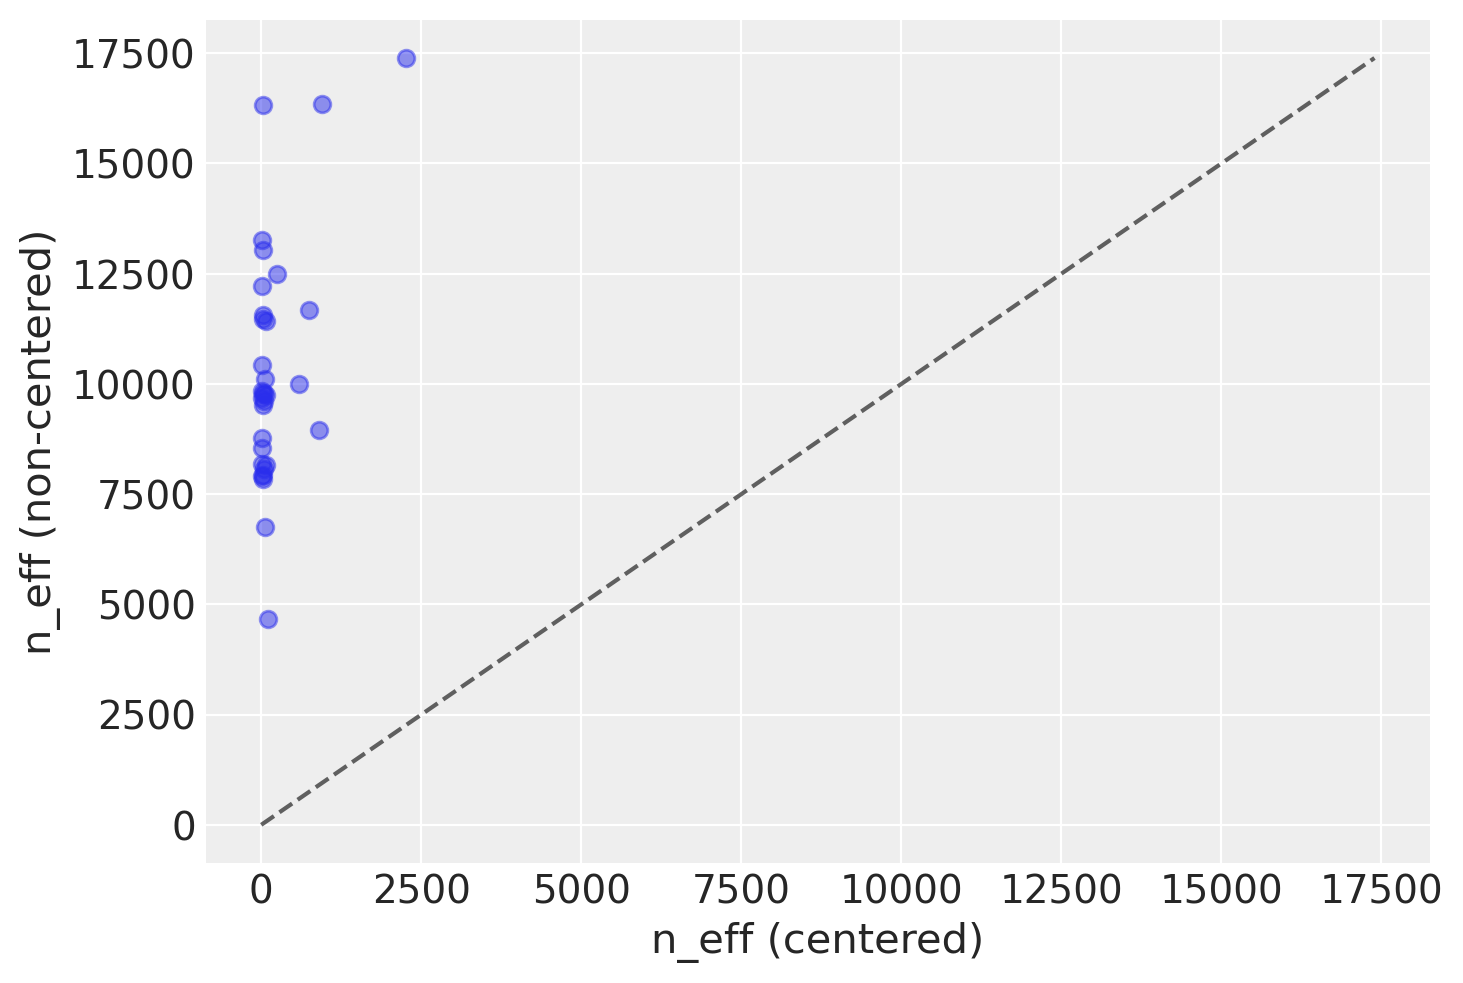

In [27]:
plt.plot(ess_mean.m14_2.values, ess_mean.m14_3.values, "o", alpha=0.5)

max_val = ess_mean.max().max()
plt.plot(np.arange(max_val), np.arange(max_val), "k--", alpha=0.6)

plt.xlabel("n_eff (centered)")
plt.ylabel("n_eff (non-centered)");

#### Code 14.21

In [28]:
az.summary(trace_14_3, var_names="sigma", filter_vars="like", round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
sigma_actor[0]  1.40  0.50      0.69       2.12       0.01     0.00   6389.69   
sigma_actor[1]  0.91  0.41      0.32       1.48       0.01     0.00   6611.21   
sigma_actor[2]  1.85  0.57      0.97       2.63       0.01     0.00   8015.88   
sigma_actor[3]  1.59  0.61      0.73       2.45       0.01     0.01   5427.44   
sigma_block[0]  0.41  0.32      0.00       0.79       0.00     0.00   5484.53   
sigma_block[1]  0.43  0.33      0.01       0.84       0.00     0.00   4042.96   
sigma_block[2]  0.31  0.27      0.01       0.64       0.01     0.00   2439.45   
sigma_block[3]  0.48  0.37      0.01       0.94       0.01     0.01   1761.16   

                ess_tail  r_hat  
sigma_actor[0]   9313.70    1.0  
sigma_actor[1]   8590.17    1.0  
sigma_actor[2]   9084.08    1.0  
sigma_actor[3]   5953.27    1.0  
sigma_block[0]   6139.98    1.0  
sigma_block[1]   3697.62    1.0  
sigma_block[2]   2947.53    1.0  
sigma_block[3]   1542.72    1.0

#### Code 14.22

In [29]:
# compute mean for each actor in each treatment
pl = d.groupby(["actor", "treatment"]).agg("mean")["pulled_left"].unstack()
pl_val = pl.stack().values
pl

treatment         0         1         2         3
actor                                            
0          0.333333  0.500000  0.277778  0.555556
1          1.000000  1.000000  1.000000  1.000000
2          0.277778  0.611111  0.166667  0.333333
3          0.333333  0.500000  0.111111  0.444444
4          0.333333  0.555556  0.277778  0.500000
5          0.777778  0.611111  0.555556  0.611111
6          0.777778  0.833333  0.944444  1.000000

In [30]:
# generate posterior predictions
with m14_3:
    pm.set_data(
        {
            "actor": np.repeat(range(7), 4),
            "block_id": np.repeat(4, 4 * 7),
            "tid": list(range(4)) * 7,
        }
    )
    post_pred = pm.sample_posterior_predictive(trace_14_3, random_seed=RANDOM_SEED, var_names="p")
    p_post = post_pred["posterior_predictive"]["p"]
p_mu = np.array(p_post.mean(dim=["chain", "draw"])).reshape((7, 4))

Sampling: []


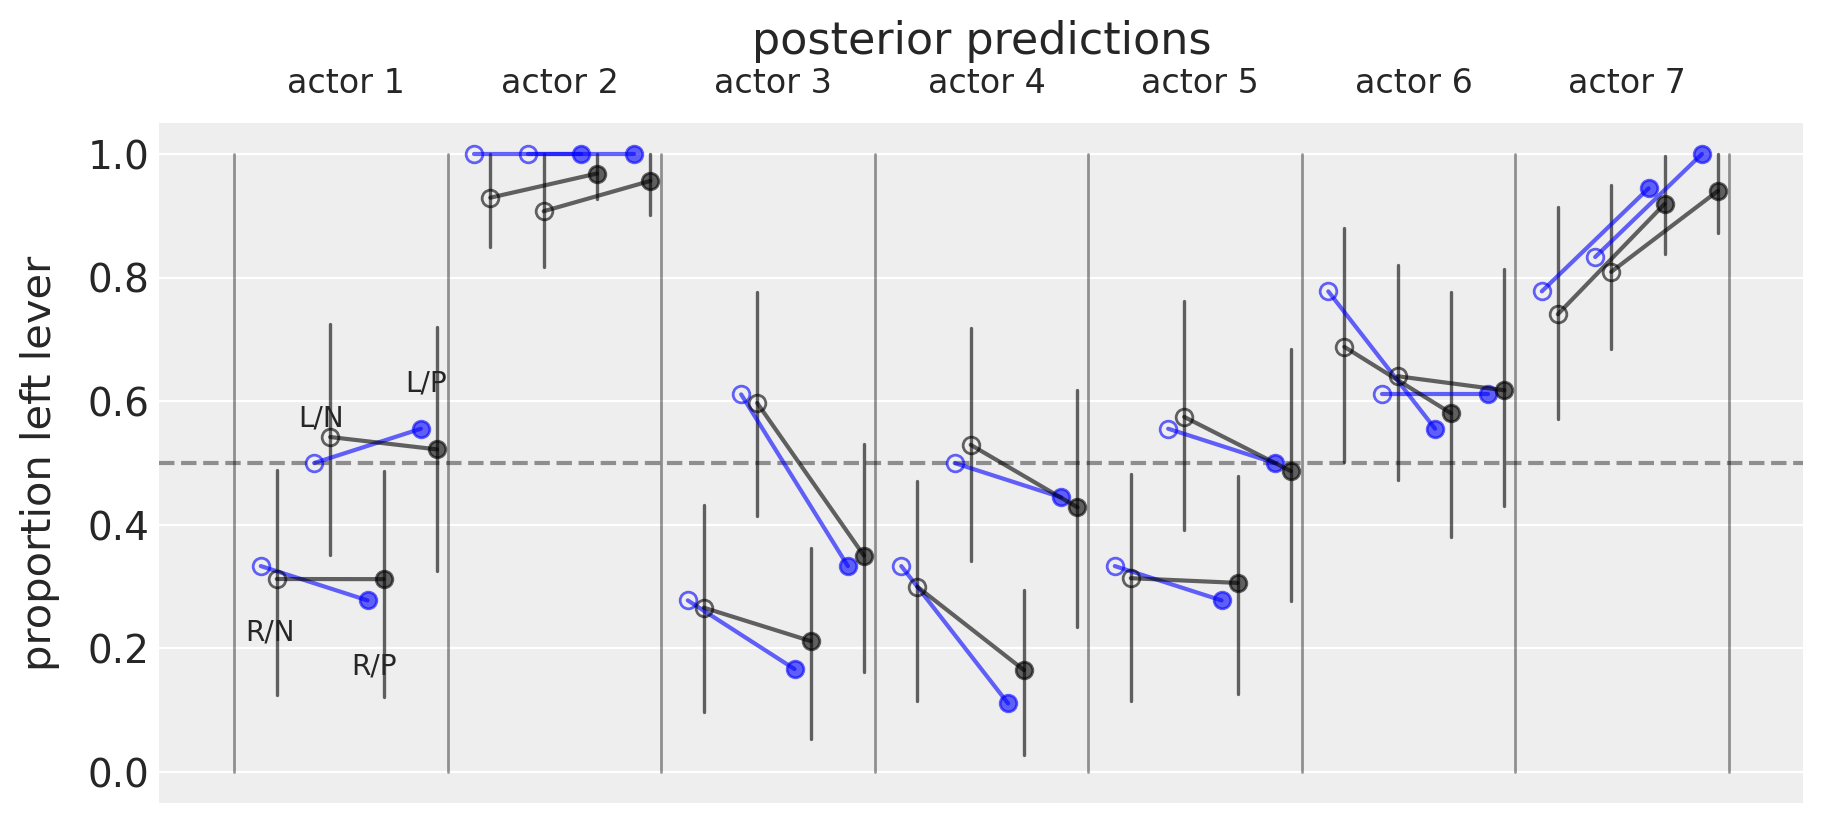

In [31]:
# set up plot
_, ax = plt.subplots(1, 1, figsize=(9, 4), constrained_layout=True)
alpha, xoff, yoff = 0.6, 0.3, 0.06

ax.plot(
    [np.arange(28) + xoff, np.arange(28) + xoff],
    np.array(az.hdi(p_post).to_array())[0].T,
    "k-",
    lw=1.2,
    alpha=alpha,
)
ax.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax.axhline(0.5, ls="--", c="k", alpha=0.4)

for actor in range(Nactors):
    # raw data
    ax.plot(
        [actor * 4, actor * 4 + 2],
        [pl.loc[actor, 0], pl.loc[actor, 2]],
        "-",
        c="b",
        alpha=alpha,
    )
    ax.plot(
        [actor * 4 + 1, actor * 4 + 3],
        [pl.loc[actor, 1], pl.loc[actor, 3]],
        "-",
        c="b",
        alpha=alpha,
    )
    ax.plot(
        [actor * 4, actor * 4 + 1],
        [pl.loc[actor, 0], pl.loc[actor, 1]],
        "o",
        c="b",
        fillstyle="none",
        ms=6,
        alpha=alpha,
    )
    ax.plot(
        [actor * 4 + 2, actor * 4 + 3],
        [pl.loc[actor, 2], pl.loc[actor, 3]],
        "o",
        c="b",
        ms=6,
        alpha=alpha,
    )
    # posterior predictions
    ax.plot(
        [actor * 4 + xoff, actor * 4 + 2 + xoff],
        [p_mu[actor, 0], p_mu[actor, 2]],
        "-",
        c="k",
        alpha=alpha,
    )
    ax.plot(
        [actor * 4 + 1 + xoff, actor * 4 + 3 + xoff],
        [p_mu[actor, 1], p_mu[actor, 3]],
        "-",
        c="k",
        alpha=alpha,
    )
    ax.plot(
        [actor * 4 + xoff, actor * 4 + 1 + xoff],
        [p_mu[actor, 0], p_mu[actor, 1]],
        "o",
        c="k",
        fillstyle="none",
        ms=6,
        alpha=alpha,
    )
    ax.plot(
        [actor * 4 + 2 + xoff, actor * 4 + 3 + xoff],
        [p_mu[actor, 2], p_mu[actor, 3]],
        "o",
        c="k",
        ms=6,
        alpha=alpha,
    )
    ax.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)

    if actor == 0:
        ax.text(actor * 4 - xoff, pl.loc[actor, 0] - 2 * yoff, "R/N")
        ax.text(actor * 4 + 1 - xoff, pl.loc[actor, 1] + yoff, "L/N")
        ax.text(actor * 4 + 2 - xoff, pl.loc[actor, 2] - 2 * yoff, "R/P")
        ax.text(actor * 4 + 3 - xoff, pl.loc[actor, 3] + yoff, "L/P")

ax.set_xticks([])
ax.set_ylabel("proportion left lever", labelpad=10)
ax.set_title("posterior predictions", pad=25);

#### Code 14.23

In [32]:
N = 500
U_sim = np.random.normal(size=N)
Q_sim = np.random.randint(1, 5, N)
E_sim = np.random.normal(loc=U_sim + Q_sim, size=N)
W_sim = np.random.normal(loc=U_sim + 0 * E_sim, size=N)
dat_sim = pd.DataFrame.from_dict(
    {"W": standardize(W_sim), "E": standardize(E_sim), "Q": standardize(Q_sim)}
)
dat_sim.head()

W         E         Q
0  0.604595 -1.288176 -1.353594
1 -1.706863 -1.664662 -1.353594
2  0.162489  1.263041  0.413500
3 -2.134704 -0.376008  0.413500
4  0.717056  0.212956  0.413500

#### Code 14.24

In [33]:
with pm.Model() as m14_4:
    aW = pm.Normal("aW", 0.0, 0.2)
    bEW = pm.Normal("bEW", 0.0, 0.5)

    mu = aW + bEW * dat_sim.E.values
    sigma = pm.Exponential("sigma", 1.0)

    W_obs = pm.Data("W_obs", dat_sim.W.values, mutable=True)
    W = pm.Normal("W", mu, sigma, observed=W_obs)

    trace_14_4 = pm.sample(random_seed=RANDOM_SEED)
az.summary(trace_14_4, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, bEW, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
aW    -0.00  0.04     -0.06       0.06        0.0      0.0   6459.49   
bEW    0.43  0.04      0.37       0.50        0.0      0.0   6070.57   
sigma  0.91  0.03      0.86       0.95        0.0      0.0   6097.38   

       ess_tail  r_hat  
aW      3076.77    1.0  
bEW     2964.70    1.0  
sigma   2800.28    1.0

#### Code 14.25

In [34]:
with pm.Model() as m14_5:
    aW = pm.Normal("aW", 0.0, 0.2)
    bEW = pm.Normal("bEW", 0.0, 0.5)
    bQW = pm.Normal("bQW", 0.0, 0.5)

    mu = aW + bEW * dat_sim.E.values + bQW * dat_sim.Q.values
    sigma = pm.Exponential("sigma", 1.0)

    W = pm.Normal("W", mu, sigma, observed=dat_sim.W.values)

    trace_14_5 = pm.sample(random_seed=RANDOM_SEED)
az.summary(trace_14_5, round_to=2);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, bEW, bQW, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


#### Code 14.26

In [35]:
with pm.Model() as m14_6:
    aW = pm.Normal("aW", 0.0, 0.2)
    aE = pm.Normal("aE", 0.0, 0.2)
    bEW = pm.Normal("bEW", 0.0, 0.5)
    bQE = pm.Normal("bQE", 0.0, 0.5)

    muW = aW + bEW * dat_sim.E.values
    muE = aE + bQE * dat_sim.Q.values
    chol, _, _ = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    WE_obs = pm.Data("WE_obs", dat_sim[["W", "E"]].values, mutable=True)
    WE = pm.MvNormal("WE", mu=at.stack([muW, muE]).T, chol=chol, observed=WE_obs)

    trace_14_6 = pm.sample(2000, random_seed=RANDOM_SEED)
    trace_14_6.rename({"chol_cov_corr": "Rho", "chol_cov_stds": "Sigma"}, inplace=True)

az.summary(trace_14_6, var_names=["aW", "aE", "bEW", "bQE", "Rho", "Sigma"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
aW        -0.00  0.04     -0.07       0.07        0.0      0.0   7535.72   
aE        -0.00  0.03     -0.05       0.06        0.0      0.0   7803.74   
bEW        0.07  0.07     -0.04       0.19        0.0      0.0   4223.80   
bQE        0.61  0.04      0.56       0.67        0.0      0.0   6746.20   
Rho[0, 0]  1.00  0.00      1.00       1.00        0.0      0.0   8000.00   
Rho[0, 1]  0.46  0.06      0.37       0.55        0.0      0.0   4234.36   
Rho[1, 0]  0.46  0.06      0.37       0.55        0.0      0.0   4234.36   
Rho[1, 1]  1.00  0.00      1.00       1.00        0.0      0.0   7618.16   
Sigma[0]   0.97  0.04      0.91       1.04        0.0      0.0   4979.94   
Sigma[1]   0.79  0.03      0.75       0.83        0.0      0.0  11262.90   

           ess_tail  r_hat  
aW          5863.29    1.0  
aE          6278.63    1.0  
bEW         4648.24    1.0  
bQE         5620.14    1.0  
Rho[0, 0]   8000.00    NaN  
Rho[0, 1]   5225.66    1.0  
Rho[1, 0]   5225.66    1.0  
Rho[1, 1]   7734.14    1.0  
Sigma[0]    5593.35    1.0  
Sigma[1]    6463.14    1.0

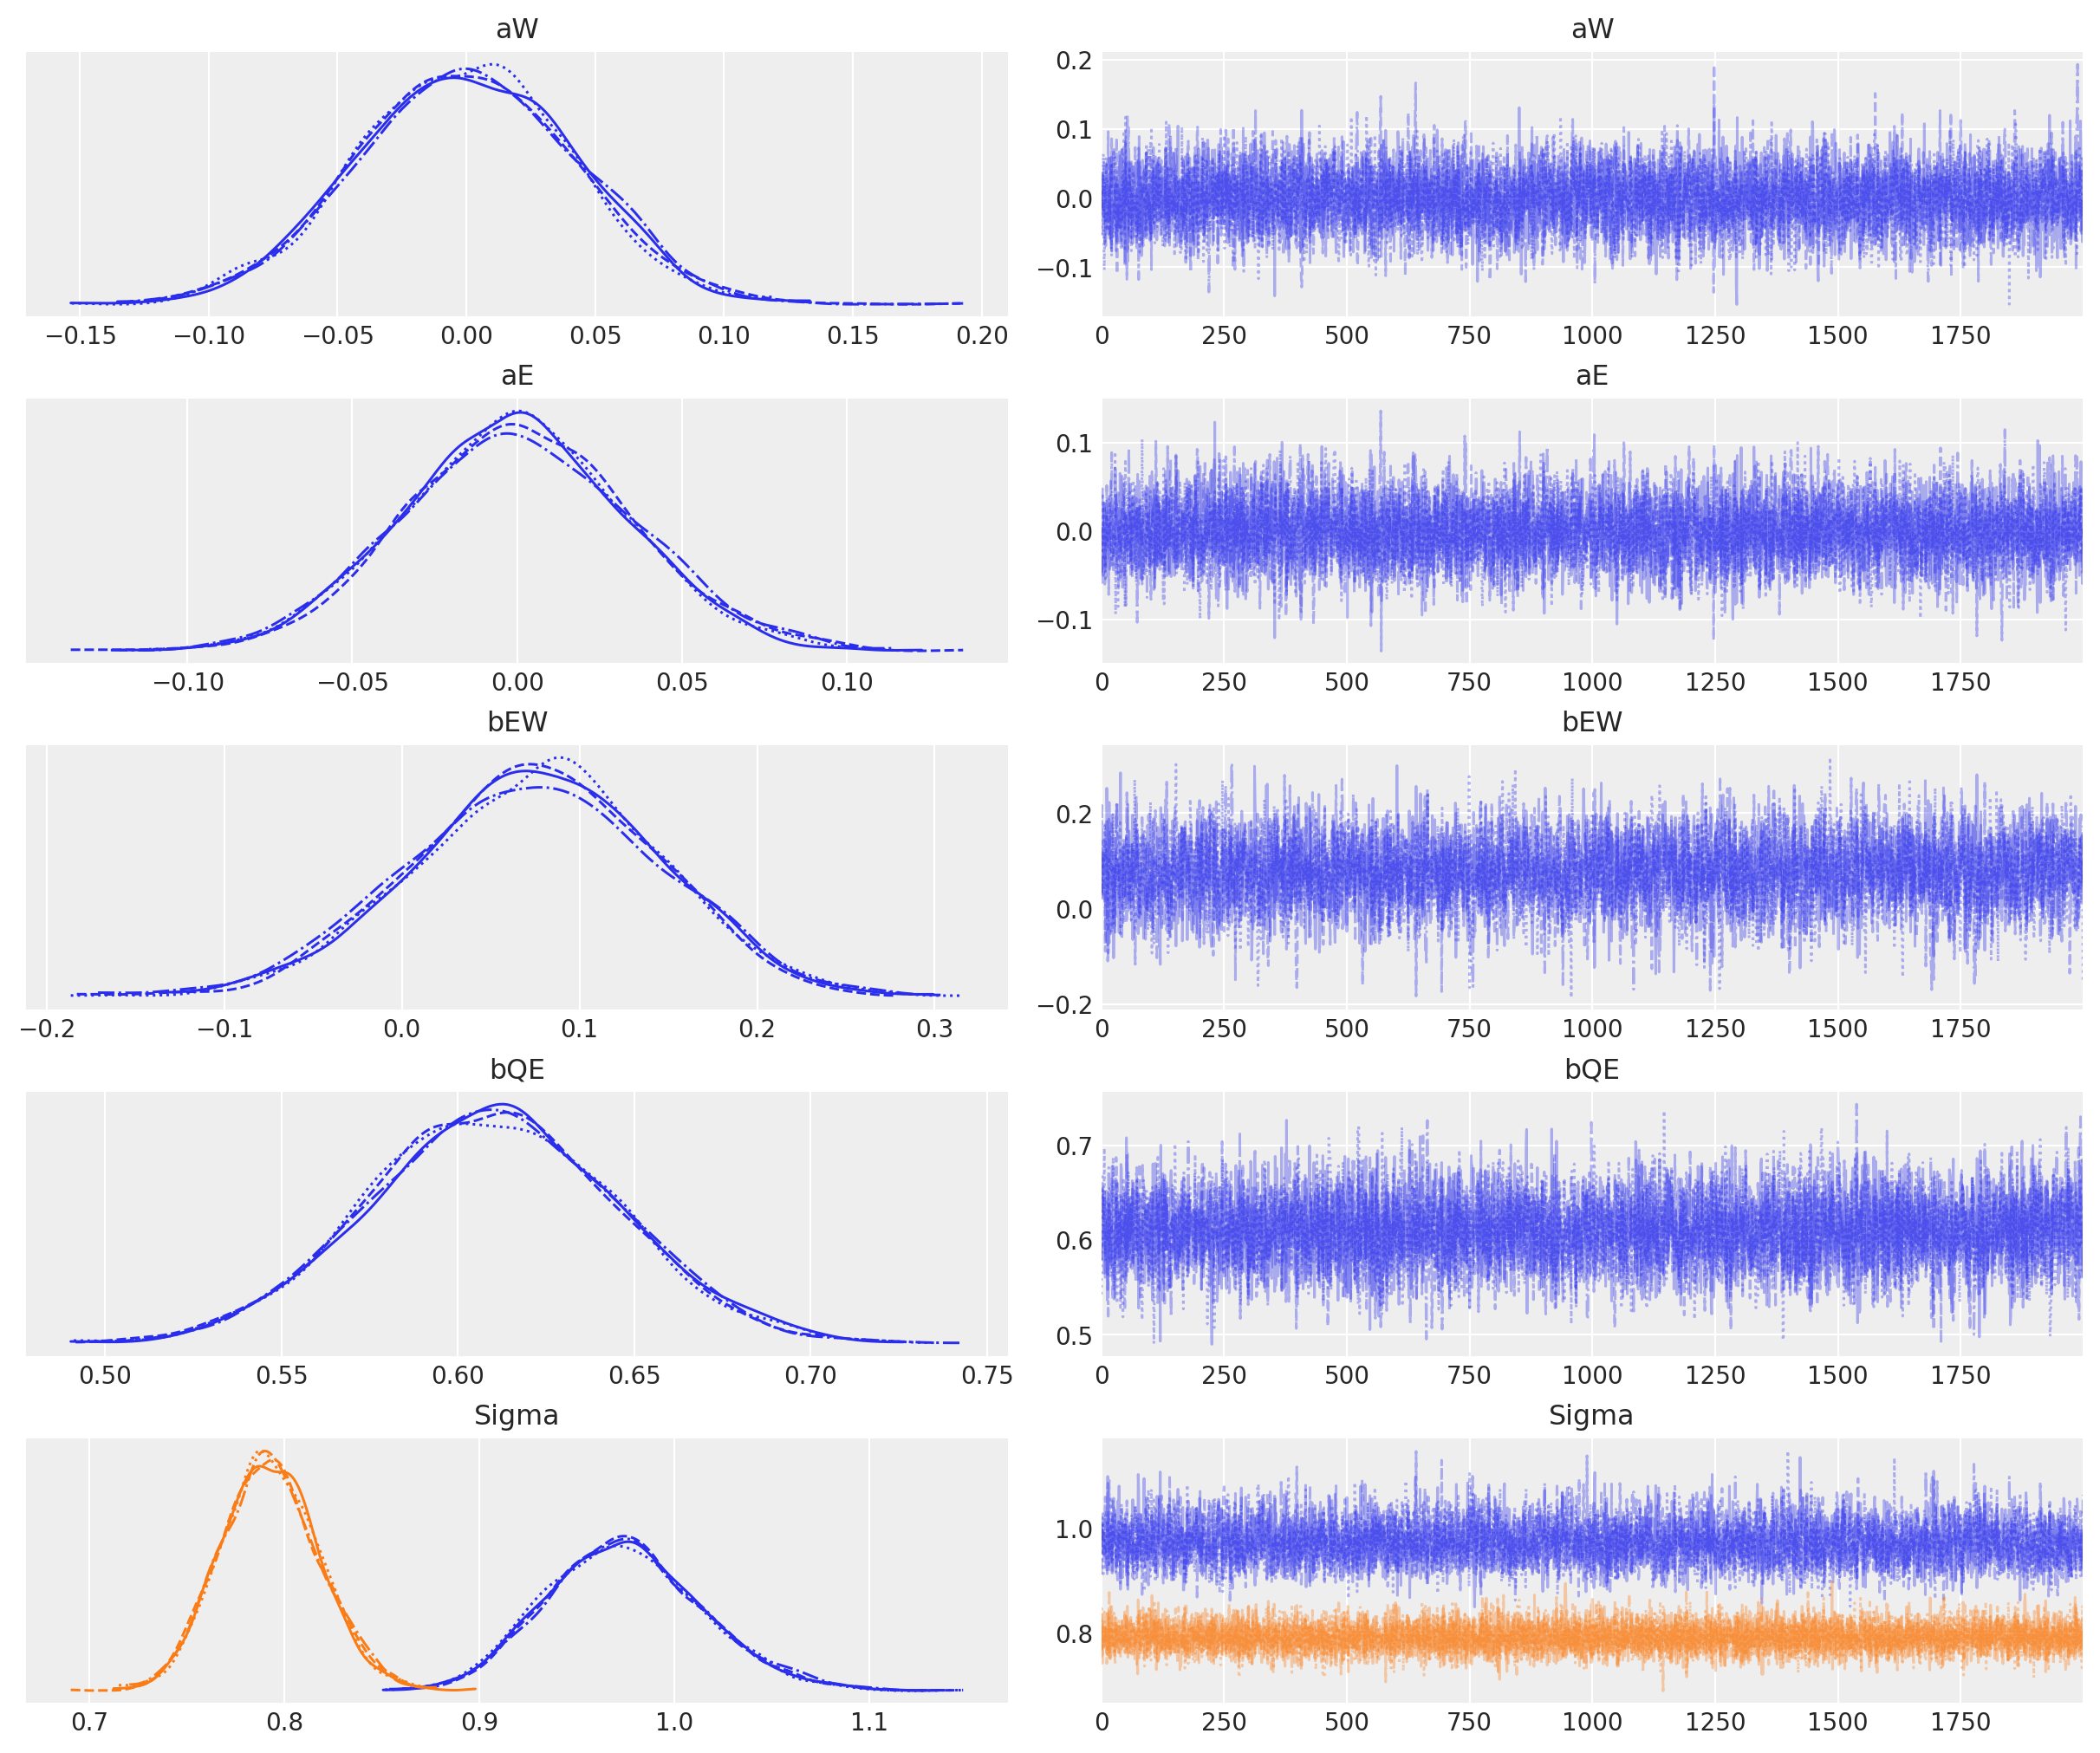

In [36]:
# Not displaying Rho variable as it causes error
az.plot_trace(trace_14_6, var_names=["aW", "aE", "bEW", "bQE", "Sigma"], compact=True);

#### Code 14.27

In [37]:
with m14_4:
    pm.set_data({"W_obs": dat_sim.W.values})  # replace `dat_sim.W` with new obs
    trace_14_4x = pm.sample(random_seed=RANDOM_SEED)

with m14_6:
    pm.set_data(
        {"WE_obs": dat_sim[["W", "E"]].values}
    )  # replace `dat_sim[["W", "E"]].values` with new obs
    trace_14_6x = pm.sample(2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, bEW, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


#### Code 14.28

In [38]:
N = 500
U_sim = np.random.normal(size=N)
Q_sim = np.random.randint(1, 5, N)
E_sim = np.random.normal(loc=U_sim + Q_sim, size=N)
W_sim = np.random.normal(loc=-U_sim + 0.2 * E_sim, size=N)
dat_sim2 = pd.DataFrame.from_dict(
    {"W": standardize(W_sim), "E": standardize(E_sim), "Q": standardize(Q_sim)}
)
dat_sim2.head()

W         E         Q
0 -0.917416  1.350022  1.311090
1 -0.870565 -1.356785  0.419192
2  1.142681 -0.546050  1.311090
3  0.700979  0.547991 -1.364604
4  0.270847 -1.382342 -1.364604

In [39]:
with m14_4:
    pm.set_data({"W_obs": dat_sim2.W.values})
    trace_14_4x = pm.sample(random_seed=RANDOM_SEED)

with m14_6:
    pm.set_data({"WE_obs": dat_sim2[["W", "E"]].values})
    trace_14_6x = pm.sample(2000, random_seed=RANDOM_SEED)
trace_14_6x.posterior = trace_14_6x.posterior.rename_vars(
    {"chol_cov_corr": "Rho", "chol_cov_stds": "Sigma"}
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, bEW, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


In [40]:
az.summary(trace_14_6x, var_names=["aW", "aE", "bEW", "bQE", "Rho", "Sigma"], round_to=2)

G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
aW         0.00  0.04     -0.07       0.07        0.0      0.0  10122.97   
aE        -0.00  0.05     -0.07       0.07        0.0      0.0   9555.64   
bEW       -0.07  0.04     -0.14       0.00        0.0      0.0  10655.16   
bQE        0.01  0.04     -0.06       0.08        0.0      0.0   8927.53   
Rho[0, 0]  1.00  0.00      1.00       1.00        0.0      0.0   8000.00   
Rho[0, 1] -0.16  0.04     -0.23      -0.09        0.0      0.0   8764.82   
Rho[1, 0] -0.16  0.04     -0.23      -0.09        0.0      0.0   8764.82   
Rho[1, 1]  1.00  0.00      1.00       1.00        0.0      0.0   7599.36   
Sigma[0]   1.00  0.03      0.95       1.05        0.0      0.0  10277.23   
Sigma[1]   1.00  0.03      0.95       1.05        0.0      0.0  11099.93   

           ess_tail  r_hat  
aW          6750.36    1.0  
aE          6774.64    1.0  
bEW         6716.74    1.0  
bQE         6338.87    1.0  
Rho[0, 0]   8000.00    NaN  
Rho[0, 1]   6539.75    1.0  
Rho[1, 0]   6539.75    1.0  
Rho[1, 1]   7932.69    1.0  
Sigma[0]    6598.94    1.0  
Sigma[1]    6457.93    1.0

#### Code 14.29

Using [`causalgraphicalmodels`](https://github.com/ijmbarr/causalgraphicalmodels) for graph drawing and analysis instead of `dagitty`, following the example of [fehiepsi's NumPyro version of Rethinking](https://github.com/fehiepsi/rethinking-numpyro).

In [41]:
from causalgraphicalmodels import CausalGraphicalModel

dagIV = CausalGraphicalModel(
    nodes=["E", "W", "U", "Q"], edges=[("E", "W"), ("U", "E"), ("U", "W"), ("Q", "E")]
)

for s in dagIV.observed_variables:
    if s in ["E", "W"]:
        continue
    cond1 = not dagIV.is_d_separated(s, "E")
    cond2 = dagIV.do("E").is_d_separated(s, "W")
    if cond1 and cond2:
        print(s)

ModuleNotFoundError: No module named 'causalgraphicalmodels'

#### Code 14.30

In [ ]:
kl_dyads = pd.read_csv("Data/KosterLeckie.csv")
kl_dyads

#### Code 14.31

In [ ]:
N = len(kl_dyads)
N_households = kl_dyads.hidB.max()
did = (kl_dyads.did - 1).values
hidA = (kl_dyads.hidA - 1).values
hidB = (kl_dyads.hidB - 1).values

To specify the matrix `d` of dyad effects, you can't force the standard deviations to be the same in PyMC (at least not yet ;)). The model will infer it though, as they are basically the same. To convince you, just run:
```python
az.summary(idata_14_7, var_names=["Rho_d", "sigma_d"], round_to=2)
```

In [ ]:
with pm.Model() as m14_7:
    ## gr matrix of varying effects
    sd_dist = pm.Exponential.dist(1.0)
    chol_gr, _, _ = pm.LKJCholeskyCov("chol_gr", n=2, eta=4, sd_dist=sd_dist, compute_corr=True)
    gr = pm.MvNormal("gr", mu=0.0, chol=chol_gr, shape=(N_households, 2))

    ## dyad effects
    chol_dyad, _, _ = pm.LKJCholeskyCov("chol_dyad", n=2, eta=8, sd_dist=sd_dist, compute_corr=True)
    z = pm.Normal("z", 0.0, 1.0, shape=(2, N))
    d = pm.Deterministic("d", pm.math.dot(chol_dyad, z).T)

    # linear models
    a = pm.Normal("a", mu=0.0, sigma=1.0)
    lambdaAB = pm.math.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[did, 0])
    lambdaBA = pm.math.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[did, 1])

    giftsAB = pm.Poisson("giftsAB", lambdaAB, observed=kl_dyads.giftsAB)
    giftsBA = pm.Poisson("giftsBA", lambdaBA, observed=kl_dyads.giftsBA)

    trace_14_7 = pm.sample(2000, tune=3000, random_seed=RANDOM_SEED)

post = trace_14_7.posterior = trace_14_7.posterior.rename_vars(
    {
        "chol_gr_corr": "Rho_gr",
        "chol_gr_stds": "sigma_gr",
        "chol_dyad_corr": "Rho_d",
        "chol_dyad_stds": "sigma_d",
    }
)

#### Code 14.32

In [ ]:
az.summary(trace_14_7, var_names=["Rho_gr", "sigma_gr"], round_to=2)

#### Code 14.33

In [ ]:
g = (post["a"] + post["gr"].sel({"gr_dim_1": 0})).stack(sample=("chain", "draw"))
r = (post["a"] + post["gr"].sel({"gr_dim_1": 1})).stack(sample=("chain", "draw"))
Eg_mu = np.exp(g).mean(dim="sample")
Er_mu = np.exp(r).mean(dim="sample")

#### Code 14.34

Adapted from [fehiepsi's port](https://fehiepsi.github.io/rethinking-numpyro/14-adventures-in-covariance.html#Code-14.34) of _Rethinking_ to NumPyro:

In [ ]:
_, ax = plt.subplots(1, 1, constrained_layout=True)
x = np.linspace(0, 9, 101)
ax.plot(x, x, "k--", lw=1.5, alpha=0.4)

# ellipses
for house in range(25):
    Sigma = np.cov(np.stack([np.exp(g[house].values), np.exp(r[house].values)]))
    Mu = np.stack([np.exp(g[house].values.mean()), np.exp(r[house].values.mean())])

    pearson = Sigma[0, 1] / np.sqrt(Sigma[0, 0] * Sigma[1, 1])
    ellipse = Ellipse(
        (0, 0),
        np.sqrt(1 + pearson),
        np.sqrt(1 - pearson),
        edgecolor="k",
        alpha=0.5,
        facecolor="none",
    )
    std_dev = stats.norm.ppf((1 + np.sqrt(0.5)) / 2)
    scale_x = 2 * std_dev * np.sqrt(Sigma[0, 0])
    scale_y = 2 * std_dev * np.sqrt(Sigma[1, 1])
    scale = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y)
    ellipse.set_transform(scale.translate(Mu[0], Mu[1]) + ax.transData)
    ax.add_patch(ellipse)

# household means
ax.plot(Eg_mu, Er_mu, "ko", mfc="white", lw=1.5)

ax.set(
    xlim=(0, 8.6),
    ylim=(0, 8.6),
    xlabel="generalized giving",
    ylabel="generalized receiving",
);

#### Code 14.35

In [ ]:
az.summary(trace_14_7, var_names=["Rho_d", "sigma_d"], round_to=2)

#### Code 14.36

In [ ]:
dy1 = post["d"].sel({"d_dim_1": 0}).mean(dim=("chain", "draw"))
dy2 = post["d"].sel({"d_dim_1": 1}).mean(dim=("chain", "draw"))

In [ ]:
_, ax = plt.subplots(1, 1, constrained_layout=True)
x = np.linspace(-2, 4, 101)

ax.plot(x, x, "k--", lw=1.5, alpha=0.4)
ax.axhline(linewidth=1.5, color="k", ls="--", alpha=0.4)
ax.axvline(linewidth=1.5, color="k", ls="--", alpha=0.4)
ax.plot(dy1, dy2, "ko", mfc="none", lw=1.5, alpha=0.6)

ax.set(
    xlim=(-2, 4),
    ylim=(-2, 4),
    xlabel="household A in dyad",
    ylabel="household B in dyad",
);

#### Code 14.37

In [ ]:
Dmat = pd.read_csv("Data/islandsDistMatrix.csv", sep=",", index_col=0)
Dmat.round(1)

#### Code 14.38

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

xrange = np.linspace(0, 4, 100)
# linear
ax.plot(xrange, np.exp(-1 * xrange), "k--", label="linear")
# squared
ax.plot(xrange, np.exp(-1 * xrange**2), "k", label="squared")

ax.set_xlabel("distance")
ax.set_ylabel("correlation")
plt.legend();

#### Code 14.39

In [ ]:
# load the ordinary data, now with coordinates
dk = pd.read_csv("Data/Kline2.csv", sep=",")

Nsociety = dk.shape[0]
society = np.arange(Nsociety)
total_tools = dk.total_tools.values

Dmat = Dmat.values
Dmatsq = np.power(Dmat, 2)

P = standardize(np.log(dk.population)).values
P = P + np.abs(P.min()) + 0.1  # must be > 0, see chp 11

dk

In [ ]:
with pm.Model() as m14_8:
    a = pm.Exponential("a", 1.0)
    b = pm.Exponential("b", 1.0)
    g = pm.Exponential("g", 1.0)

    etasq = pm.Exponential("etasq", 2.0)
    ls_inv = pm.HalfNormal("ls_inv", 2.0)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv**2)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)

    lam = (a * P**b / g) * at.exp(k[society])

    T = pm.Poisson("total_tools", lam, observed=total_tools)

    trace_14_8 = pm.sample(4000, tune=2000, target_accept=0.99, random_seed=RANDOM_SEED)

In [ ]:
az.plot_trace(trace_14_8, var_names=["~k_rotated_"], compact=True);

#### Code 14.40

In [ ]:
az.summary(trace_14_8, var_names=["~k_rotated_"], round_to=2)

#### Code 14.41

In [ ]:
# compute posterior median covariance
x_seq = np.linspace(0, 10, 100)
post = trace_14_8.posterior.stack(sample=("chain", "draw"))
pmcov_mu = post["etasq"].median().values * np.exp(-post["rhosq"].median().values * (x_seq**2))

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))

# plot functions sampled from posterior
ax.plot(
    x_seq,
    (
        post["etasq"][::50].values[:, None]
        * np.exp(-post["rhosq"][::50].values[:, None] * (x_seq**2))
    ).T,
    "k",
    alpha=0.08,
)

# plot median covariance function
ax.plot(x_seq, pmcov_mu, lw=3)

ax.set(
    title="Gaussian process posterior",
    ylim=(-0.1, 2),
    xlabel="distance (thousand km)",
    ylabel="covariance",
);

#### Code 14.42

In [ ]:
# compute posterior median covariance among societies
K = post["etasq"].median().values * np.exp(-post["rhosq"].median().values * Dmatsq) + np.diag(
    [0.01] * Nsociety
)

#### Code 14.43

In [ ]:
# convert to correlation matrix
sigma_post = np.sqrt(np.diag(K))
Rho = (sigma_post**-1) * K * (sigma_post**-1)

# add row/col names for convenience
Rho = pd.DataFrame(
    Rho,
    index=["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"],
    columns=["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"],
)

Rho.round(2)

#### Code 14.44 and 14.45

There seems to be a typo in the book: the posterior predictive computations in the second plot are done according to the model from the first edition: $\lambda = exp(\alpha + \beta_p x logpop)$. We'll use the right version here, i.e the model that we just ran above: $\lambda = \frac{\alpha P^\beta}{\gamma}$.

In [ ]:
# Code 14.44
# scale point size to logpop
logpop = np.copy(dk["logpop"].values)
logpop /= logpop.max()
psize = np.exp(logpop * 5.5)

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# plot raw data and labels
ax0.scatter(dk["lon2"], dk["lat"], psize, alpha=0.6)
labels = dk["culture"].values
for i, itext in enumerate(labels):
    ax0.text(dk["lon2"][i] + 1, dk["lat"][i] + 1, itext)

# overlay lines shaded by Rho
for i in range(10):
    for j in np.arange(i + 1, 10):
        ax0.plot(
            [dk["lon2"][i], dk["lon2"][j]],
            [dk["lat"][i], dk["lat"][j]],
            "k-",
            alpha=Rho.iloc[i, j] ** 2,
            lw=2.5,
        )

ax0.set_xlabel("longitude")
ax0.set_ylabel("latitude")

# Code 14.45
# compute posterior median relationship, ignoring distance
P_seq = np.linspace(-1.4, 3.0, 30) + 1.4  # our little trick from chp 11
lambda_post = (
    post["a"].values[:, None] * P_seq ** post["b"].values[:, None] / post["g"].values[:, None]
)

# plot raw data and labels
ax1.scatter(P, dk["total_tools"], psize, alpha=0.6)
labels = dk["culture"].values
for i, itext in enumerate(labels):
    ax1.text(P[i] + 0.1, dk["total_tools"][i] - 2.5, itext)

# display posterior predictions
ax1.plot(P_seq, np.median(lambda_post, axis=0), "--", color="k", alpha=0.8)
az.plot_hdi(
    P_seq,
    lambda_post,
    color="k",
    ax=ax1,
    fill_kwargs={"alpha": 0},
    plot_kwargs={"color": "k", "ls": "--", "alpha": 0.8},
)

# overlay correlations
for i in range(10):
    for j in np.arange(i + 1, 10):
        ax1.plot(
            [P[i], P[j]],
            [dk["total_tools"][i], dk["total_tools"][j]],
            "k-",
            alpha=Rho.iloc[i, j] ** 2,
            lw=2.5,
        )

ax1.set_xlabel("standardized population")
ax1.set_ylabel("total tools");

#### Code 14.46

Related to Stan. PyMC's GP module automatically reparametrizes with the Cholesky factor of the covariance matrix under the hood.

#### Code 14.47

The `ape`-package-related computations are very specific to the example and not related to PyMC usage, so let's just load the CSV file and the ready-made image:

In [42]:
Primates301 = pd.read_csv("Data/Primates301.csv", sep=";")

![image](Data/Primates301.png)

#### Code 14.48

In [55]:
dpymc = Primates301.dropna(subset=["group_size", "body", "brain"])
spp_obs = dpymc["name"].index
dpymc

name           genus       species subspecies  \
0    Allenopithecus_nigroviridis  Allenopithecus  nigroviridis        NaN   
2              Alouatta_belzebul        Alouatta      belzebul        NaN   
3                Alouatta_caraya        Alouatta        caraya        NaN   
4               Alouatta_guariba        Alouatta       guariba        NaN   
5              Alouatta_palliata        Alouatta      palliata        NaN   
..                           ...             ...           ...        ...   
294      Trachypithecus_obscurus  Trachypithecus      obscurus        NaN   
295       Trachypithecus_phayrei  Trachypithecus       phayrei        NaN   
296      Trachypithecus_pileatus  Trachypithecus      pileatus        NaN   
298       Trachypithecus_vetulus  Trachypithecus       vetulus        NaN   
300  Varecia_variegata_variegata         Varecia     variegata  variegata   

     spp_id  genus_id  social_learning  research_effort   brain     body  \
0         1         1              0.0              6.0   58.02   4655.0   
2         3         3              0.0             15.0   52.84   6395.0   
3         4         3              0.0             45.0   52.63   5383.0   
4         5         3              0.0             37.0   51.70   5175.0   
5         6         3              3.0             79.0   49.88   6250.0   
..      ...       ...              ...              ...     ...      ...   
294     295        67              0.0              6.0   62.12   7056.0   
295     296        67              0.0             16.0   72.84   7475.0   
296     297        67              0.0              5.0  103.64  11794.0   
298     299        67              0.0              2.0   61.29   6237.0   
300     301        68              0.0             57.0   32.12   3575.0   

     group_size  gestation  weaning  longevity  sex_maturity  \
0         40.00        NaN   106.15      276.0           NaN   
2          7.40        NaN      NaN        NaN           NaN   
3          8.90     185.92   323.16      243.6       1276.72   
4          7.40        NaN      NaN        NaN           NaN   
5         13.10     185.42   495.60      300.0       1578.42   
..          ...        ...      ...        ...           ...   
294       10.00     146.63   362.93      300.0           NaN   
295       12.90     180.61   305.87        NaN           NaN   
296        8.50        NaN      NaN        NaN           NaN   
298        8.35     204.72   245.78      276.0       1113.70   
300        2.80     102.50    90.73      384.0        701.52   

     maternal_investment  
0                    NaN  
2                    NaN  
3                 509.08  
4                    NaN  
5                 681.02  
..                   ...  
294               509.56  
295               486.48  
296                  NaN  
298               450.50  
300               193.23  

[151 rows x 16 columns]

#### Code 14.49

In [56]:
N_spp = len(dpymc)
M = standardize(np.log(dpymc.body.values))
B_ = standardize(np.log(dpymc.brain.values))
G = standardize(np.log(dpymc.group_size.values))
Imat = np.diag(np.ones(N_spp))

In [57]:
with pm.Model() as m14_9:
    a = pm.Normal("a", 0.0, 1.0)
    bM = pm.Normal("bM", 0.0, 0.5)
    bG = pm.Normal("bG", 0.0, 0.5)
    sigma_sq = pm.Exponential("sigma_sq", 1.0)

    mu = a + bM * M + bG * G
    SIGMA = Imat * sigma_sq
    B = pm.MvNormal("B", mu, cov=SIGMA, observed=B_)

    trace_14_9 = pm.sample(random_seed=RANDOM_SEED)
az.summary(trace_14_9, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, bG, sigma_sq]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a         0.00  0.02     -0.03       0.03        0.0      0.0   4229.16   
bM        0.89  0.02      0.86       0.93        0.0      0.0   2577.81   
bG        0.12  0.02      0.09       0.16        0.0      0.0   2530.16   
sigma_sq  0.05  0.01      0.04       0.06        0.0      0.0   4090.70   

          ess_tail  r_hat  
a          2777.30    1.0  
bM         2759.22    1.0  
bG         2734.01    1.0  
sigma_sq   3158.88    1.0

#### Code 14.50

The `ape`-package-related computations are very specific to the example and not related to PyMC usage, so let's just load the CSV files:

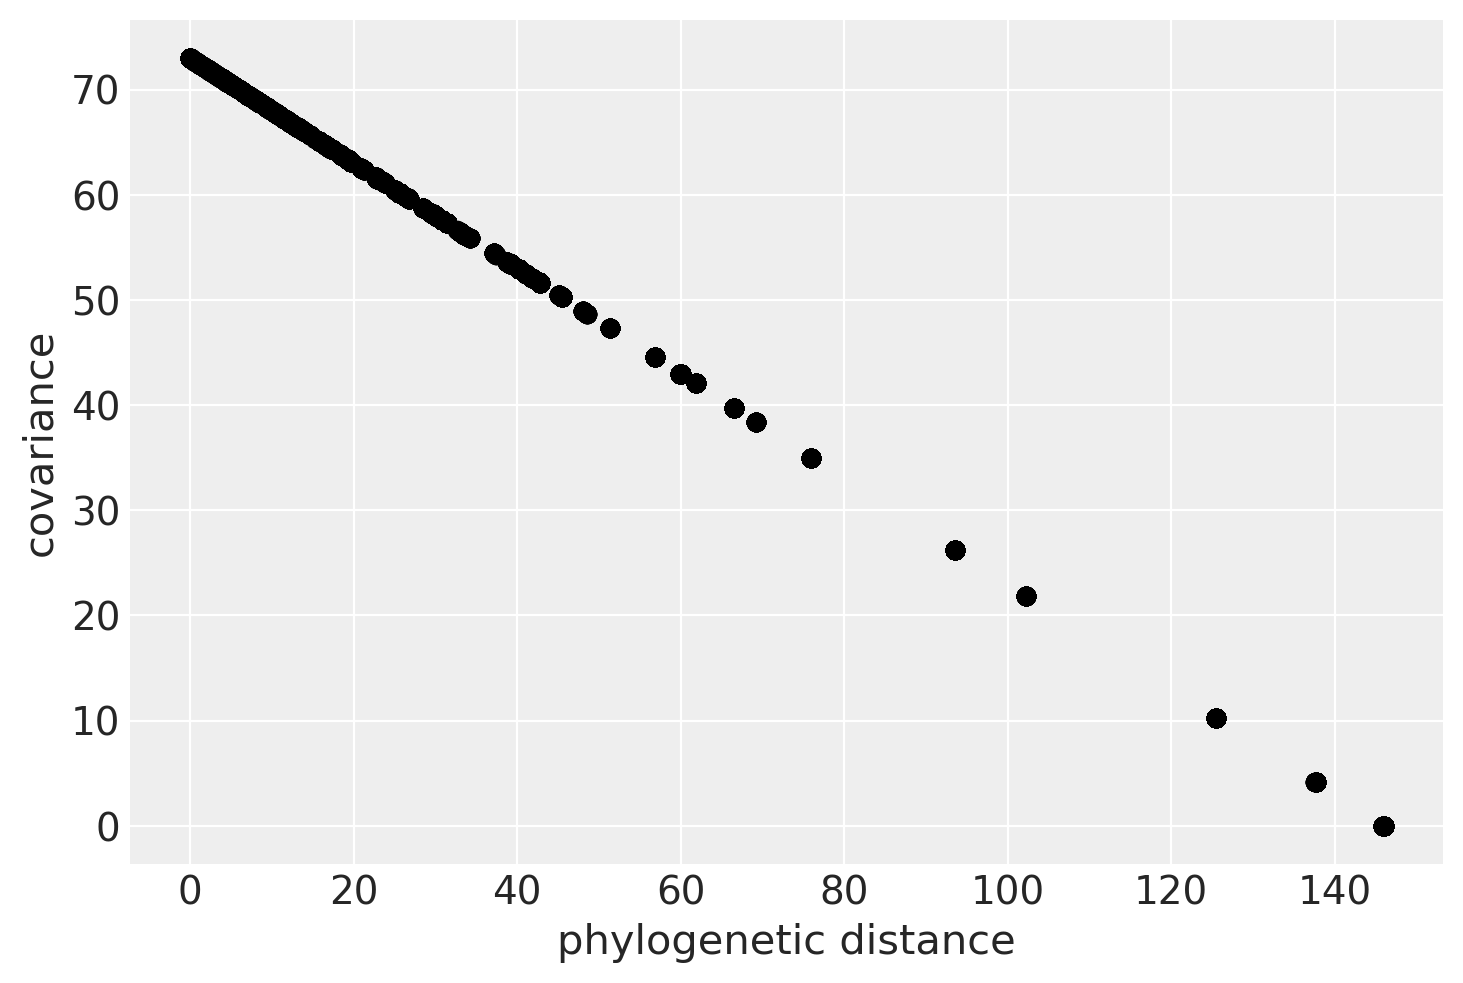

In [58]:
import rdata
parsed = rdata.parser.parse_file('Data/Primates301_distance_matrix.rda')
converted = rdata.conversion.convert(parsed)
Dmat = converted['Primates301_distance_matrix']

parsed = rdata.parser.parse_file('Data/Primates301_vcov_matrix.rda')
converted = rdata.conversion.convert(parsed)
V = converted['Primates301_vcov_matrix']
plt.plot(Dmat, V, "ko")
plt.xlabel("phylogenetic distance")
plt.ylabel("covariance");

#### Code 14.51

In [60]:
V

<xarray.DataArray (dim_0: 301, dim_1: 301)>
array([[73.003018, 61.108116, 61.108116, ...,  4.162986,  4.162986,
         4.162986],
       [61.108116, 73.003019, 66.57381 , ...,  4.162986,  4.162986,
         4.162986],
       [61.108116, 66.57381 , 73.003019, ...,  4.162986,  4.162986,
         4.162986],
       ...,
       [ 4.162986,  4.162986,  4.162986, ..., 73.003019, 70.705655,
        48.705367],
       [ 4.162986,  4.162986,  4.162986, ..., 70.705655, 73.003019,
        48.705367],
       [ 4.162986,  4.162986,  4.162986, ..., 48.705367, 48.705367,
        73.003019]])
Coordinates:
  * dim_0    (dim_0) <U41 'Allenopithecus_nigroviridis' ... 'Tarsius_syrichta'
  * dim_1    (dim_1) <U41 'Allenopithecus_nigroviridis' ... 'Tarsius_syrichta'

In [61]:
# put species in right order
V_ord = V[spp_obs, spp_obs]
# convert to correlation matrix
R = (V_ord / V_ord.max()).values

In [62]:
# Brownian motion model
with pm.Model() as m14_10:
    a = pm.Normal("a", 0.0, 1.0)
    bM = pm.Normal("bM", 0.0, 0.5)
    bG = pm.Normal("bG", 0.0, 0.5)
    sigma_sq = pm.Exponential("sigma_sq", 1.0)

    mu = a + bM * M + bG * G
    SIGMA = R * sigma_sq
    B = pm.MvNormal("B", mu, cov=SIGMA, observed=B_)

    trace_14_10 = pm.sample(random_seed=RANDOM_SEED)
az.summary(trace_14_10, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, bG, sigma_sq]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a         0.01  0.38     -0.57       0.64        0.0     0.01   6503.54   
bM        0.89  0.01      0.87       0.91        0.0     0.00   5686.95   
bG       -0.01  0.01     -0.02       0.01        0.0     0.00   5579.19   
sigma_sq  0.92  0.11      0.75       1.09        0.0     0.00   6215.04   

          ess_tail  r_hat  
a          3005.04    1.0  
bM         2979.56    1.0  
bG         3395.04    1.0  
sigma_sq   3243.38    1.0

#### Code 14.52

In [64]:
# scale and reorder distance matrix
Dmat_ord = (Dmat[spp_obs, spp_obs] / Dmat[spp_obs, spp_obs].max()).values

This is a good opportunity to show a use-case of PyMC's GP module. In the Oceanic tools example above, we didn't need a mean function (which means it was automatically set to 0 by PyMC). Now however, we need both a mean function _and_ a covariance function to specify our GP. The covariance function will look familiar. For the mean function, we could use `gp.mean.Linear`, which takes as input a matrix of coefficients and a vector of intercepts. But that mean function would then be evaluated on our distance matrix, as `SIGMA` will be.

We don't want that -- we only want the mean function to depend on `M` and `G` not on the phylogenetic distance. We can easily [define a custom mean function](https://docs.pymc.io/notebooks/GP-MeansAndCovs.html#Defining-a-custom-mean-function) in PyMC. We just need to subclass `pm.gp.mean.Mean` and provide `__call__` and `__init__` methods:

In [65]:
class LinearMean(pm.gp.mean.Mean):
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes

    def __call__(self, X):
        """In the trace summary, b0 will be bM and b1 will be bG"""
        return self.intercept + self.slopes[0] * M + self.slopes[1] * G

And we can easily use this function in our model below. Notice we use `pm.gp.Marginal` and `gp.marginal_likelihood` instead of `pm.gp.Latent` and `gp.prior` as in the Oceanic tools example. It's because here we have a (multivariate) normal likelihood, which works well analytically with a GP prior, so `Marginal` and `marginal_likelihood` just take advantage of the closed-form solution to speed-up computations. It's also why you see no calls to `pm.MvNormal` below: this is implicit in `marginal_likelihood`, which evaluates the GP at the `X` points (`Dmat_ord`). And do you recall what the evaluation of a GP is? An MvNormal random variable -- bingo!

In [81]:
Dmat_ord[:1]

array([[0.        , 0.16293713, 0.16293712, 0.16293712, 0.16293714,
        0.16293714, 0.16293712, 0.16293713, 0.16293713, 0.16293713,
        0.16293712, 0.16293712, 0.16293712, 0.16293712, 0.16293713,
        0.99994997, 0.99999997, 0.99999997, 0.99999997, 0.99999997,
        0.99999997, 0.99999998, 0.99999998, 0.99999998, 0.99999997,
        0.99999997, 0.99999998, 0.99999998, 0.99999998, 0.99999997,
        0.99999997, 0.99999997, 0.99999997, 0.99999997, 0.99999997,
        0.99999997, 0.99999997, 0.99999997, 0.99999997, 0.99999997,
        0.99999997, 0.99999997, 0.99999997, 0.99999997, 0.99999998,
        0.99999998, 0.99999997, 0.99999997, 0.99999997, 0.99999997,
        0.99999997, 0.99999997, 0.99999997, 0.99999997, 0.6412313 ,
        0.6412313 , 0.64123131, 0.64123131, 0.6412313 , 0.6412313 ,
        0.6412313 , 0.6412313 , 0.6412313 , 0.6412313 , 0.64123131,
        0.6412313 , 0.64123131, 0.64123129, 0.64123129, 0.64123129,
        0.64123129, 0.64123129, 0.64123128, 0.64

In [82]:
M[:5]

array([0.37081759, 0.57793271, 0.46558162, 0.43988157, 0.56297503])

In [84]:
B_[:5]

array([0.4052928 , 0.32966992, 0.3264498 , 0.31203305, 0.2830535 ])

In [85]:
G[:5]

array([1.40192255, 0.0031425 , 0.15614399, 0.0031425 , 0.47658604])

In [66]:
with pm.Model() as m14_11:
    a = pm.Normal("a", 0.0, 1.0)
    b = pm.Normal("b", 0.0, 0.5, shape=2)
    # specify the mean function:
    mu = LinearMean(intercept=a, slopes=b)

    # half_normal(1, 0.25) is too strong
    etasq = pm.Exponential("etasq", 1.0)
    rhosq = pm.Normal("rhosq", 3.0, 0.25)
    # specify the covariance function:
    SIGMA = etasq * pm.gp.cov.Exponential(input_dim=1, ls=rhosq)

    # specify the GP:
    gp = pm.gp.Marginal(mean_func=mu, cov_func=SIGMA)

    # place a GP prior over the observations.
    # SIGMA will be conditioned on Dmat_ord.
    # mu won't be, as we coded it on purpose.
    sigma = pm.Exponential("sigma", 1.0)
    B = gp.marginal_likelihood("B", X=Dmat_ord, y=B_, noise=sigma)

    trace_14_11 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

# b0 is bM and b1 is bG
az.summary(trace_14_11, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, etasq, rhosq, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 202 seconds.


mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a     -0.00  0.31     -0.47       0.49        0.0      0.0   4856.70   
b[0]   0.90  0.02      0.86       0.93        0.0      0.0   5226.46   
b[1]   0.11  0.02      0.08       0.15        0.0      0.0   5303.12   
rhosq  3.01  0.25      2.64       3.44        0.0      0.0   7641.79   
etasq  0.13  0.17      0.00       0.28        0.0      0.0   3499.19   
sigma  0.21  0.01      0.19       0.23        0.0      0.0   6729.26   

       ess_tail  r_hat  
a       3361.51    1.0  
b[0]    5146.32    1.0  
b[1]    5406.96    1.0  
rhosq   5268.09    1.0  
etasq   2466.75    1.0  
sigma   5523.51    1.0

All the posteriors are looking good and similar to the book, except for `etasq`. If you replace `etasq = pm.Exponential('etasq', 1.0)` by  `etasq = pm.Normal('etasq', 1.0, 0.25)`, you will see that this prior is too strong and is not moved by the data, which is why I changed it. Moreover, I don't understand how the results for `etasq` reported in the book could be so close to 0 ($[0.03, 0.05]$), especially with a prior as strong as `half_normal(1, 0.25)`.

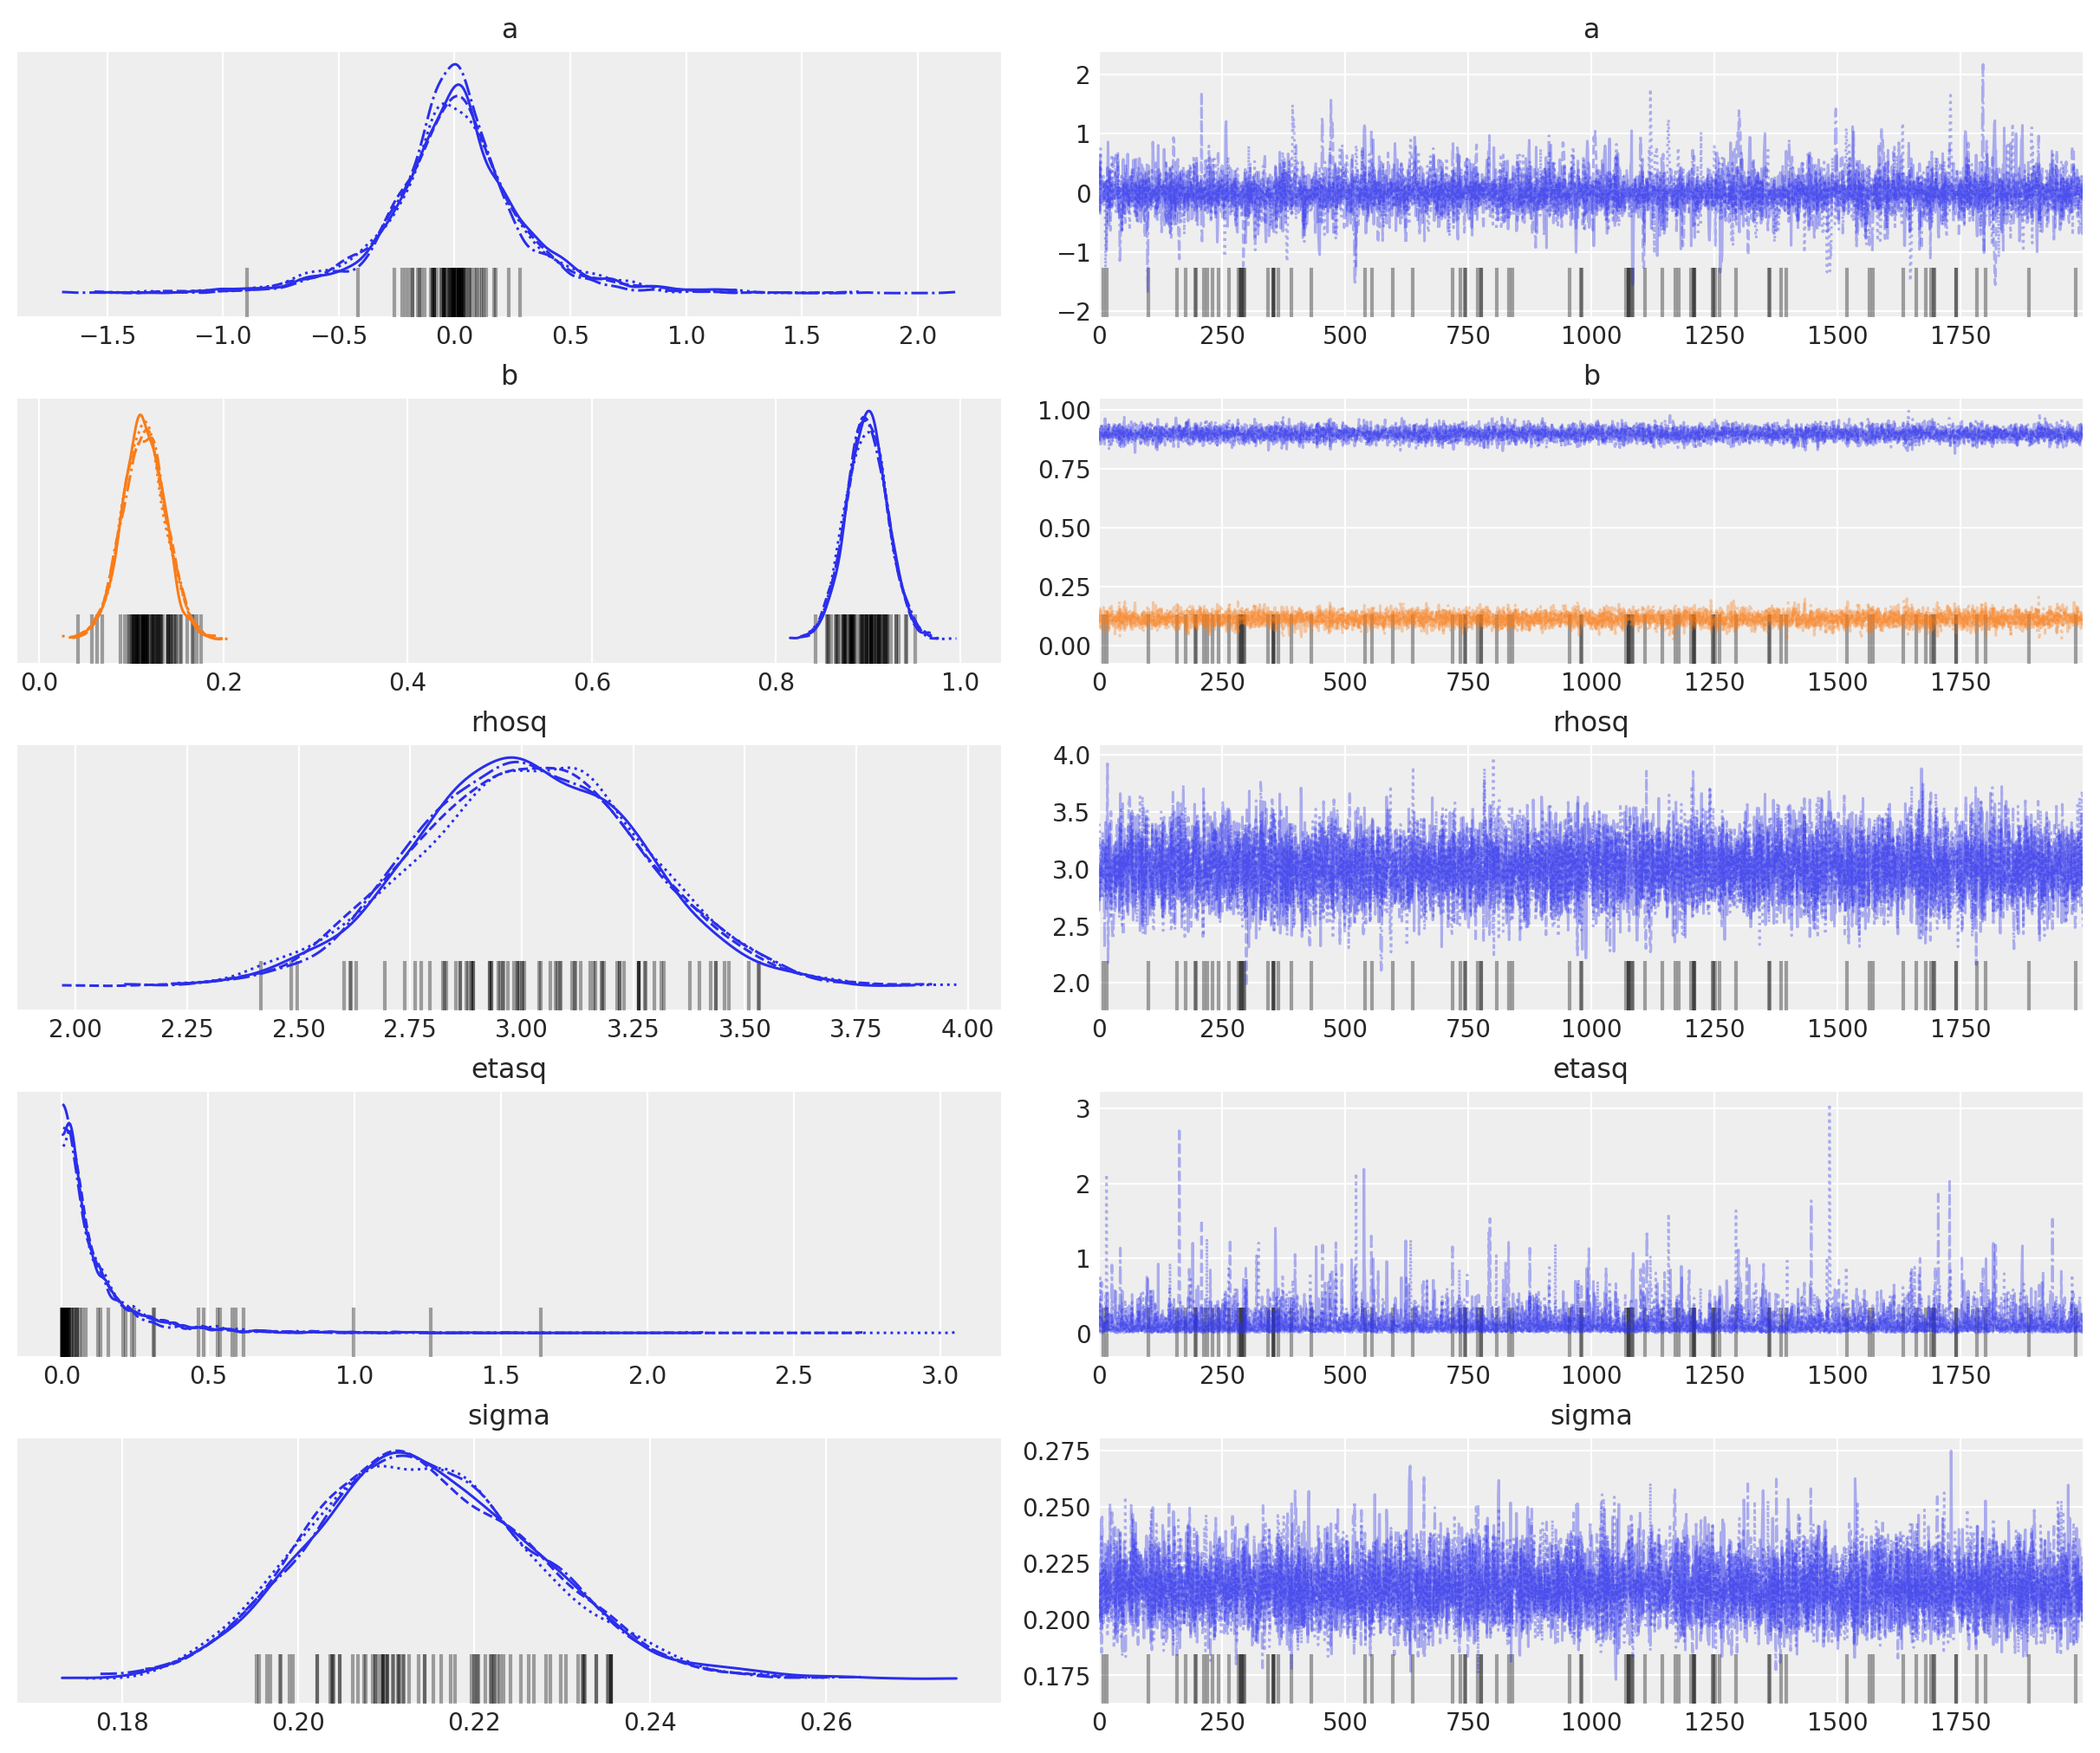

In [67]:
az.plot_trace(trace_14_11, compact=True);

#### Code 14.53

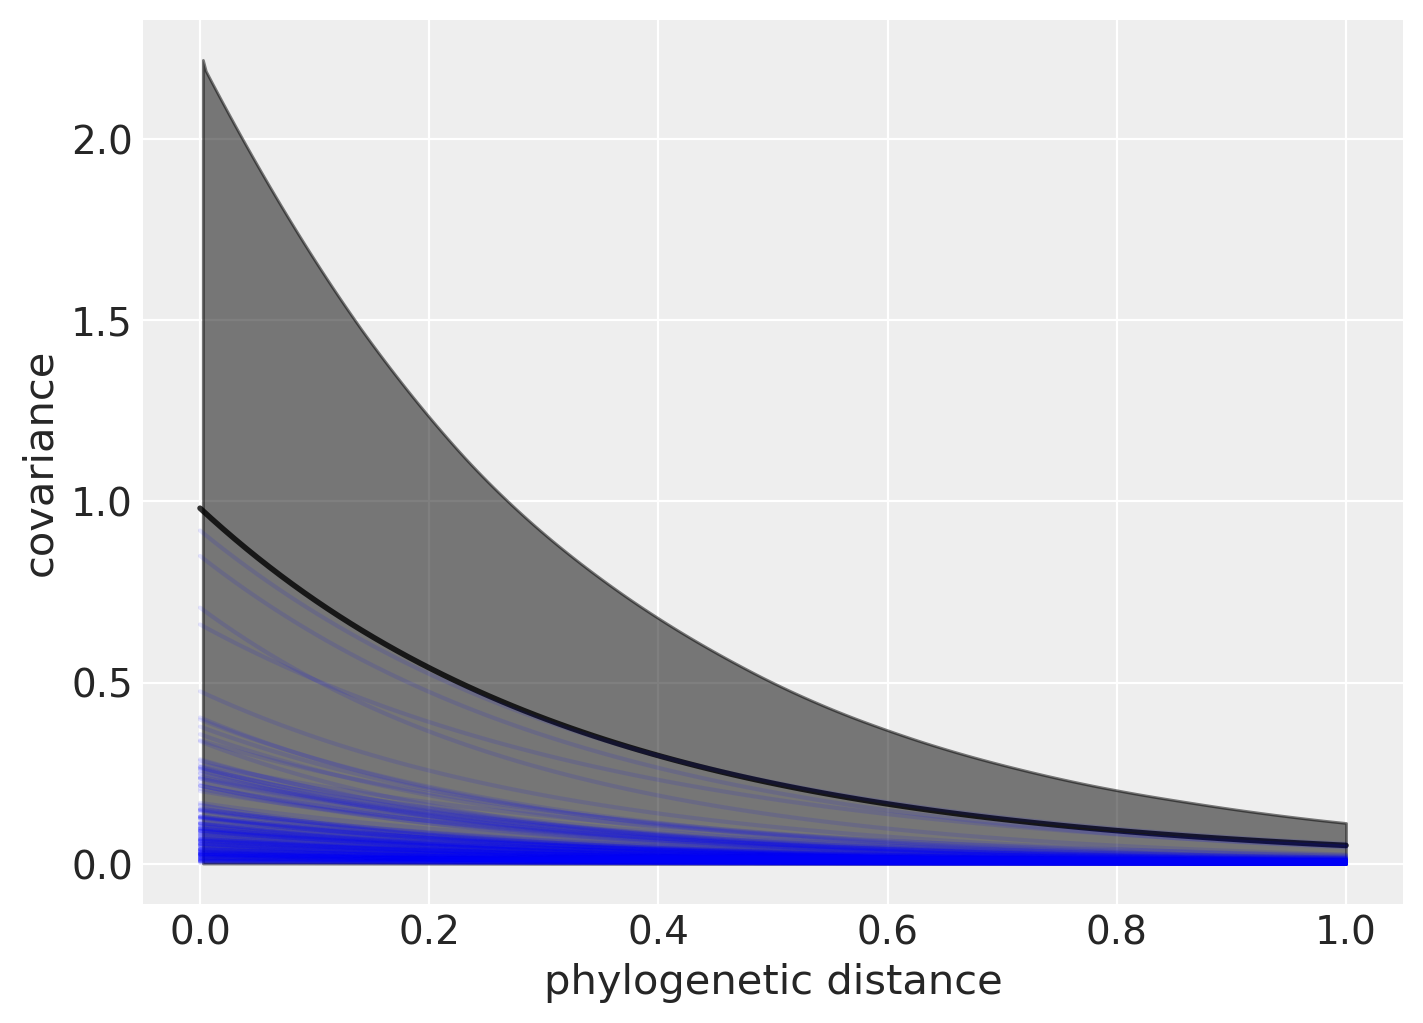

In [68]:
d_seq = np.linspace(0, Dmat_ord.max(), 100)
post = trace_14_11.posterior.stack(sample=("chain", "draw"))

_, ax = plt.subplots(1, 1, figsize=(7, 5))

# prior mean and 89% interval
eta = np.random.exponential(1.0, 1000)
rho = np.random.normal(3.0, 0.25, 1000)
K = []
for d in d_seq:
    K.append(eta * np.exp(-rho * d))
K = np.asarray(K)

ax.plot(d_seq, K.mean(1), "k", alpha=0.8, lw=2)
az.plot_hdi(d_seq, K.T, color="k", ax=ax)

# posterior
post_etasq = post["etasq"][::50].values[:, None]
post_rhosq = post["rhosq"][::50].values[:, None]
ax.plot(d_seq, (post_etasq * np.exp(-post_rhosq * d_seq)).T, "b", alpha=0.1)

ax.set(xlabel="phylogenetic distance", ylabel="covariance");